<a href="https://colab.research.google.com/github/Alfaxad/gemma2-swahili-models/blob/main/Gemma2_Swahili_Benchmarking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gemma2 Swahili Language Models: Comprehensive Benchmarking

Authors: [Alfaxad Eyembe](https://alfaxad.github.io/), [Mrina Mtenga](https://www.kaggle.com/mrinaeliseus)

Note: This notebook was run on google colab, High-Ram environment with A100 GPU

## TL;DR: Performance Highlights

### Sentiment Analysis Benchmark
| Model | Base Accuracy | Fine-tuned Accuracy | Improvement |
|-------|--------------|---------------------|-------------|
| Gemma2-2B | 49.00% | 66.50% | +17.50% |
| Gemma2-9B | 83.42% | 86.50% | +3.08% |
| Gemma2-27B (4-bit) | 87.50% | 88.50% | +1.00% |

### MMLU Benchmark
| Model | Base Accuracy | Fine-tuned Accuracy | Improvement |
|-------|--------------|---------------------|-------------|
| Gemma2-2B | 15.00% | 34.17% | +19.17% |
| Gemma2-9B | 43.33% | 55.83% | +12.50% |
| Gemma2-27B (4-bit) | 20.00% | 54.17% | +34.17% |

### Translation Benchmark (Metrics with Improvement)
| Model | Metric | Improvement | Base Value | Fine-tuned Value |
|-------|--------|-------------|------------|-----------------|
| Gemma2-2B | BLEU-1 | +0.0332 | 0.3403 | 0.3735 |
| Gemma2-2B | BLEU-2 | +0.0165 | 0.2106 | 0.2271 |
| Gemma2-27B | BLEU | +0.0018 | 0.1818 | 0.1836 |
| Gemma2-27B | BLEU-1 | +0.0071 | 0.4923 | 0.4994 |
| Gemma2-27B | BLEU-2 | +0.0011 | 0.3569 | 0.3580 |

## Project Overview

### Background
This notebook presents a comprehensive benchmarking study of Gemma2 Swahili language models, exploring their performance across multiple critical natural language processing tasks. Our research focuses on fine-tuning Google's Gemma2 models IT (2B, 9B, and 27B) for Swahili language understanding and generation.
**The evaluated models were note trained on any of these benchmarks, this was done in order to test models capacity to generalize on new tasks.**

### Research Objectives
1. Evaluate base model performance in Swahili-specific tasks
2. Assess the impact of fine-tuning on model capabilities
3. Analyze performance across different model sizes
4. Provide insights into language model adaptation for low-resource languages

### Methodology Highlights
- **Datasets**:
  - Swahili Sentiment Analysis: 3,925 Swahili text samples
  - Swahili MMLU: 14,042 multi-domain questions
  - English-to-Swahili Translation: Wikimedia English-Swahili corpus

- **Benchmarking Metrics**:
  - Accuracy
  - BLEU Scores
  - Sentiment Classification
  - Multitask Language Understanding

### Computational Constraints
- Limited sample sizes due to computational resources
- 4-bit quantization for larger models
- Stratified sampling across benchmarks

### Key Limitations
- Small dataset samples
- Potential quantization performance impacts
- Computational resource constraints



In [ ]:

# Initial imports and settings
!pip install --quiet torch torchvision torchaudio
!pip install --quiet transformers accelerate datasets bitsandbytes evaluate peft sentencepiece
!pip install --quiet kagglehub

In [ ]:
import kagglehub
kagglehub.login()

Kaggle credentials set.
Kaggle credentials successfully validated.


In [ ]:
import os
import torch
import random
import numpy as np
from datasets import load_dataset, Dataset
from transformers import (
   AutoTokenizer,
   AutoModelForCausalLM,
   TrainingArguments,
   Trainer,
   DataCollatorForLanguageModeling
)
from peft import LoraConfig, get_peft_model

# Set random seed
def set_seed(seed: int):
   random.seed(seed)
   np.random.seed(seed)
   torch.manual_seed(seed)
   torch.cuda.manual_seed_all(seed)
set_seed(42)

In [ ]:
# Downloading gemma models
gemma2_2b_it_model_path = kagglehub.model_download('google/gemma-2/transformers/gemma-2-2b-it')
print(gemma2_2b_it_model_path)

/root/.cache/kagglehub/models/google/gemma-2/transformers/gemma-2-2b-it/2


In [ ]:
gemma2_9b_it_model_path = kagglehub.model_download('google/gemma-2/transformers/gemma-2-9b-it')
print(gemma2_9b_it_model_path)

/root/.cache/kagglehub/models/google/gemma-2/transformers/gemma-2-9b-it/2


In [ ]:
gemma2_27b_it_model_path = kagglehub.model_download('google/gemma-2/transformers/gemma-2-27b-it')
print(gemma2_27b_it_model_path)

/root/.cache/kagglehub/models/google/gemma-2/transformers/gemma-2-27b-it/2


In [ ]:
# Downloading The Swahili Finetuned Models
swahili_gemma2_2b_it_model_path = kagglehub.model_download('alfaxadeyembe/gemma-2-swahili/transformers/gemma2-2b-swahili-it')
print(swahili_gemma2_2b_it_model_path)

/root/.cache/kagglehub/models/alfaxadeyembe/gemma-2-swahili/transformers/gemma2-2b-swahili-it/1


In [ ]:
swahili_gemma2_9b_it_model_path = kagglehub.model_download('alfaxadeyembe/gemma-2-swahili/transformers/gemma2-9b-swahili-it')
print(swahili_gemma2_9b_it_model_path)

/root/.cache/kagglehub/models/alfaxadeyembe/gemma-2-swahili/transformers/gemma2-9b-swahili-it/1


In [ ]:
swahili_gemma2_27b_it_model_path = kagglehub.model_download('alfaxadeyembe/gemma-2-swahili/transformers/gemma2-27b-swahili-it')
print(swahili_gemma2_27b_it_model_path)


/root/.cache/kagglehub/models/alfaxadeyembe/gemma-2-swahili/transformers/gemma2-27b-swahili-it/1


# Swahili Sentiment Analysis Benchmark

## Overview
The Swahili Sentiment Analysis Benchmark is a critical evaluation of language models' ability to understand and classify the emotional tone of Swahili text. This benchmark assesses the models' capability to distinguish between positive and negative sentiments across various types of text.

The **Swahili Sentiment Analysis Dataset** is a resource developed by **Neurotech** in collaboration with **Jinamizi** to facilitate sentiment analysis in the Swahili language.

**Key Features:**

- **Binary Sentiment Classification:** The dataset is designed for training models to classify Swahili text into two sentiment categories: positive and negative.

- **Model Training Application:** This dataset has been utilized to train models such as the Spark NLP Swahili Sentiment Analysis model, enhancing the capability of natural language processing tools to accurately interpret Swahili sentiments.

We adapted this dataset and made it available for benchmarking on [Kaggle](https://www.kaggle.com/datasets/alfaxadeyembe/swahili-sentiment-dataset)


## Dataset Characteristics
- **Total Samples**: 3,925 text samples
- **Label Distribution**:
  - Positive Samples: 2,002 (51.04%)
  - Negative Samples: 1,923 (48.96%)
- **Text Length Statistics**:
  - Average Length: 66.31 characters
  - Minimum Length: 3 characters
  - Maximum Length: 459 characters

## Benchmark Methodology
### Evaluation Approach
- Stratified sampling of test set
- Prompt-based sentiment classification
- Multiple metrics for comprehensive assessment
- Detailed subject-level performance analysis

### Evaluation Metrics
1. **Accuracy**: Primary metric measuring correct sentiment predictions
2. **Response Validity**: Assessing the model's ability to generate meaningful responses

## Detailed Results

### Performance Comparison

| Model | Base Accuracy | Fine-tuned Accuracy | Improvement |
|-------|--------------|---------------------|-------------|
| Gemma2-2B | 49.00% | 66.50% | +17.50% |
| Gemma2-9B | 83.42% | 86.50% | +3.08% |
| Gemma2-27B (4-bit) | 87.50% | 88.50% | +1.00% |

### Key Observations

#### Gemma2-2B Models
- Significant improvement from base to fine-tuned model
- Demonstrates substantial learning potential
- Largest relative performance gain

#### Gemma2-9B Models
- Already strong base performance
- Modest improvement with fine-tuning
- Consistent sentiment understanding

#### Gemma2-27B Models
- High baseline accuracy
- Minimal but noticeable improvement
- Demonstrates robustness across different model sizes

## Technical Challenges
- Handling short, context-dependent Swahili text
- Distinguishing nuanced sentiments
- Maintaining performance across varied text types

## Insights
1. Fine-tuning consistently improves sentiment analysis performance
2. Smaller models (2B) show more dramatic improvements
3. Larger models maintain high baseline accuracy

## Limitations
- Small dataset size
- Potential bias in data collection
- Limited diversity of text sources

## Future Work
- Expand dataset with more diverse Swahili text
- Investigate performance on domain-specific texts
- Explore multi-label sentiment classification

## Conclusion
The Swahili Sentiment Analysis Benchmark reveals the effectiveness of fine-tuning large language models for sentiment classification, with particularly promising results for smaller model sizes.

In [ ]:
swahili_sentiment_dataset=kagglehub.dataset_download('alfaxadeyembe/swahili-sentiment-dataset')

100%|██████████| 106k/106k [00:00<00:00, 284kB/s]

Extracting files...


Dataset Overview:
--------------------------------------------------
Number of examples: 3925

Columns in dataset:
['Unnamed: 0', 'text', 'labels']

Label distribution:
labels
positive    2002
negative    1923
Name: count, dtype: int64

First few examples:
--------------------------------------------------

Example 1:
Text: team 2019merimera alikuwa takataka
Label: negative

Example 2:
Text: sijafurahishwa
Label: negative

Example 3:
Text: kubuni dosari
Label: negative


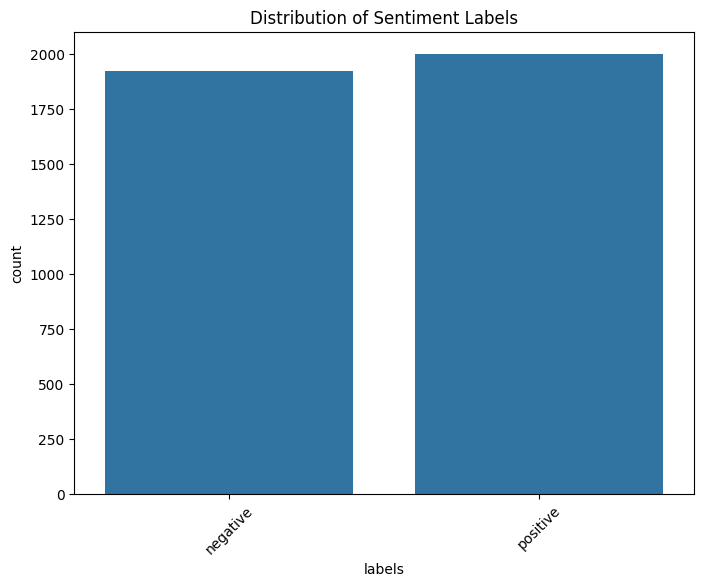


Dataset Statistics:
--------------------------------------------------
Average text length: 66.31 characters
Max text length: 459 characters
Min text length: 3 characters


In [ ]:
# Load the dataset
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
df = pd.read_csv("/root/.cache/kagglehub/datasets/alfaxadeyembe/swahili-sentiment-dataset/versions/1/swahili-sentiment.csv")

# Display basic information
print("Dataset Overview:")
print("-" * 50)
print(f"Number of examples: {len(df)}")
print("\nColumns in dataset:")
print(df.columns.tolist())
print("\nLabel distribution:")
print(df['labels'].value_counts())

# Display some examples
print("\nFirst few examples:")
print("-" * 50)
for i in range(3):
    print(f"\nExample {i+1}:")
    print(f"Text: {df.iloc[i]['text']}")
    print(f"Label: {df.iloc[i]['labels']}")

# Create a sentiment distribution plot
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='labels')
plt.title('Distribution of Sentiment Labels')
plt.xticks(rotation=45)
plt.show()

# Print some stats
print("\nDataset Statistics:")
print("-" * 50)
print(f"Average text length: {df['text'].str.len().mean():.2f} characters")
print(f"Max text length: {df['text'].str.len().max()} characters")
print(f"Min text length: {df['text'].str.len().min()} characters")

In [ ]:
def evaluate_swahili_sentiment(model_path, test_samples=200):
    test_df = df.sample(n=test_samples, random_state=42)

    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModelForCausalLM.from_pretrained(
        model_path,
        device_map="auto",
        torch_dtype=torch.bfloat16,
        low_cpu_mem_usage=True
    )

    model.eval()

    # Print two example responses at the start
    print("\nExample Responses:")
    print("-" * 50)
    for i in range(2):
        example_text = test_df.iloc[i]['text']
        example_label = test_df.iloc[i]['labels']
        prompt = (
            f"### Maagizo:\nTathmini hisia katika sentensi ifuatayo kama 'hasi' au 'chanya'.\n\n"
            f"### Text:\n{example_text}\n\n"
            f"### Jibu:\nHisia katika sentensi hii ni"
        )

        inputs = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True).to(model.device)
        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=50,
                do_sample=True,
                temperature=0.3,
                top_p=0.9
            )
        response = tokenizer.decode(outputs[0], skip_special_tokens=True)
        generated_part = response.split("Hisia katika sentensi hii ni")[-1].strip()

        print(f"\nExample {i+1}:")
        print(f"Text: {example_text}")
        print(f"True Label: {example_label}")
        print(f"Model Response: {generated_part}")
    print("-" * 50)
    print("\nStarting full evaluation...")

    correct = 0
    total = 0
    predictions = []

    for _, row in test_df.iterrows():
        prompt = (
            f"### Maagizo:\nTathmini hisia katika sentensi ifuatayo kama 'hasi' au 'chanya'.\n\n"
            f"### Text:\n{row['text']}\n\n"
            f"### Jibu:\nHisia katika sentensi hii ni"
        )

        try:
            inputs = tokenizer(
                prompt,
                return_tensors="pt",
                padding=True,
                truncation=True,
                max_length=1024
            ).to(model.device)

            with torch.no_grad():
                outputs = model.generate(
                    **inputs,
                    max_new_tokens=50,
                    do_sample=True,
                    temperature=0.3,
                    top_p=0.9,
                    pad_token_id=tokenizer.pad_token_id,
                    eos_token_id=tokenizer.eos_token_id
                )

            response = tokenizer.decode(outputs[0], skip_special_tokens=True)

            try:
                generated_part = response.split("Hisia katika sentensi hii ni")[-1].strip()
            except:
                generated_part = response

            if len(generated_part) > 0 and generated_part != prompt:
                if 'chanya' in generated_part.lower():
                    pred = 'positive'
                elif 'hasi' in generated_part.lower():
                    pred = 'negative'
                else:
                    pred = 'invalid'
            else:
                pred = 'invalid'

            predictions.append({
                'text': row['text'],
                'true_label': row['labels'],
                'predicted': pred,
                'response': generated_part
            })

            if pred != 'invalid' and pred == row['labels']:
                correct += 1
            total += 1

            # Progress updates every 50 samples
            if total % 50 == 0:
                valid_responses = len([p for p in predictions if p['predicted'] != 'invalid'])
                print(f"Processed {total}/{test_samples} samples.")
                print(f"Valid responses: {valid_responses}/{total}")
                if valid_responses > 0:
                    print(f"Accuracy on valid responses: {(correct/valid_responses)*100:.2f}%")

        except Exception as e:
            print(f"Error processing sample {total}: {str(e)}")
            continue

    # Print final analysis
    print("\nDetailed Analysis:")
    print(f"Total samples: {total}")
    valid_responses = len([p for p in predictions if p['predicted'] != 'invalid'])
    print(f"Valid responses: {valid_responses}")
    print(f"Invalid/repeated responses: {total - valid_responses}")
    if valid_responses > 0:
        print(f"Accuracy on valid responses: {(correct/valid_responses)*100:.2f}%")

    # Show a few example predictions
    print("\nSample predictions:")
    for i in range(min(2, len(predictions))):
        print(f"\nText: {predictions[i]['text']}")
        print(f"True: {predictions[i]['true_label']}")
        print(f"Predicted: {predictions[i]['predicted']}")
        print(f"Response: {predictions[i]['response'][:100]}...")

    # Clean up
    del model, inputs, outputs
    torch.cuda.empty_cache()

    return (correct/valid_responses)*100 if valid_responses > 0 else 0

In [ ]:
# Gemma2 2B evaluation on swahili sentiment analysis
gemma2_2b_it_sentiment_accuracy = evaluate_swahili_sentiment(gemma2_2b_it_model_path)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Example Responses:
--------------------------------------------------

Example 1:
Text: Kwa kweli napendekeza mahali hapa uwezapo kwenda vibaya na mahali hapa pa kufanyia kazi
True Label: positive
Model Response: "chanya".

Example 2:
Text: kwa kweli hii ni moja ya kumbukumbu bora ambayo nimeona wakiangalia uhusiano wa kifamilia na ndoa
True Label: positive
Model Response: **chanya**.
--------------------------------------------------

Starting full evaluation...
Processed 50/200 samples.
Valid responses: 50/50
Accuracy on valid responses: 54.00%
Processed 100/200 samples.
Valid responses: 100/100
Accuracy on valid responses: 51.00%
Processed 150/200 samples.
Valid responses: 150/150
Accuracy on valid responses: 50.00%
Processed 200/200 samples.
Valid responses: 200/200
Accuracy on valid responses: 49.00%

Detailed Analysis:
Total samples: 200
Valid responses: 200
Invalid/repeated responses: 0
Accuracy on valid responses: 49.00%

Sample predictions:

Text: Kwa kweli napendekeza mahali

In [ ]:
# SWahili Finetuned Gemma2 2B evaluation on swahili sentiment analysis
swahili_gemma2_2b_it_sentiment_accuracy = evaluate_swahili_sentiment(swahili_gemma2_2b_it_model_path)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Example Responses:
--------------------------------------------------

Example 1:
Text: Kwa kweli napendekeza mahali hapa uwezapo kwenda vibaya na mahali hapa pa kufanyia kazi
True Label: positive
Model Response: 'chanya' kwa sababu inaonyesha uwezekano wa kufanya mambo mazuri katika mahali hapo.

Example 2:
Text: kwa kweli hii ni moja ya kumbukumbu bora ambayo nimeona wakiangalia uhusiano wa kifamilia na ndoa
True Label: positive
Model Response: chanya.
Hisia ya kumbukumbu bora na uhusiano wa kifamilia na ndoa ni chanya.
Kwa kweli, sentensi hii inaonyesha hisia chanya kwa sababu inasema kuwa uhu
--------------------------------------------------

Starting full evaluation...
Processed 50/200 samples.
Valid responses: 50/50
Accuracy on valid responses: 72.00%
Processed 100/200 samples.
Valid responses: 100/100
Accuracy on valid responses: 71.00%
Processed 150/200 samples.
Valid responses: 150/150
Accuracy on valid responses: 67.33%
Processed 200/200 samples.
Valid responses: 200/200
Ac

In [ ]:
# Gemma2 9B evaluation on swahili sentiment analysis
gemma2_9b_it_sentiment_accuracy = evaluate_swahili_sentiment(gemma2_9b_it_model_path)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Example Responses:
--------------------------------------------------

Example 1:
Text: Kwa kweli napendekeza mahali hapa uwezapo kwenda vibaya na mahali hapa pa kufanyia kazi
True Label: positive
Model Response: **chanya**. 

**Ufafanuzi:**

* **"Napendekeza"** inaashiria hisia ya kupendeza na kuridhika.
* **"Uwezapo kwenda vibaya"** ina

Example 2:
Text: kwa kweli hii ni moja ya kumbukumbu bora ambayo nimeona wakiangalia uhusiano wa kifamilia na ndoa
True Label: positive
Model Response: **chanya**. 


### Maelezo:

Sentensi ina maneno yenye maana chanya kama vile "bora," "kumbukumbu," "uhusiano mzuri," na "ndoa."
--------------------------------------------------

Starting full evaluation...
Processed 50/200 samples.
Valid responses: 50/50
Accuracy on valid responses: 84.00%
Processed 100/200 samples.
Valid responses: 99/100
Accuracy on valid responses: 83.84%
Processed 150/200 samples.
Valid responses: 149/150
Accuracy on valid responses: 81.88%
Processed 200/200 samples.
Valid res

In [ ]:
# SWahili Finetuned Gemma2 9B evaluation on swahili sentiment analysis
swahili_gemma2_9b_it_sentiment_accuracy = evaluate_swahili_sentiment(swahili_gemma2_9b_it_model_path)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Example Responses:
--------------------------------------------------

Example 1:
Text: Kwa kweli napendekeza mahali hapa uwezapo kwenda vibaya na mahali hapa pa kufanyia kazi
True Label: positive
Model Response: hasi. 

Kwa sababu sentensi inasema "kwa kweli napendekeza mahali hapa uwezapo kwenda vibaya na mahali hapa pa kufanyia kazi", inamaanisha kuwa mahali hapo ni vib

Example 2:
Text: kwa kweli hii ni moja ya kumbukumbu bora ambayo nimeona wakiangalia uhusiano wa kifamilia na ndoa
True Label: positive
Model Response: chanya. Sentensi inathibitisha kuwa kumbukumbu hiyo ni nzuri na inahusisha uhusiano mzuri wa kifamilia na ndoa. Kwa hiyo, hisia ni chanya.
--------------------------------------------------

Starting full evaluation...
Processed 50/200 samples.
Valid responses: 50/50
Accuracy on valid responses: 86.00%
Processed 100/200 samples.
Valid responses: 100/100
Accuracy on valid responses: 86.00%
Processed 150/200 samples.
Valid responses: 150/150
Accuracy on valid response

In [ ]:
# Swahili Sentiment Evaluation Function For 27B(4-bit quantized) models
from transformers import BitsAndBytesConfig


def evaluate_swahili_sentiment_4bit(model_path, test_samples=200):
    test_df = df.sample(n=test_samples, random_state=42)

    # Configure 4-bit quantization
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.bfloat16,
        bnb_4bit_use_double_quant=True
    )

    # Load tokenizer and model with quantization
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModelForCausalLM.from_pretrained(
        model_path,
        quantization_config=bnb_config,
        device_map="auto",
        torch_dtype=torch.bfloat16,
        trust_remote_code=True
    )

    model.eval()

    # Print two example responses at the start
    print("\nExample Responses:")
    print("-" * 50)
    for i in range(2):
        example_text = test_df.iloc[i]['text']
        example_label = test_df.iloc[i]['labels']
        prompt = (
            f"### Maagizo:\nTathmini hisia katika sentensi ifuatayo kama 'hasi' au 'chanya'.\n\n"
            f"### Text:\n{example_text}\n\n"
            f"### Jibu:\nHisia katika sentensi hii ni"
        )

        inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=50,
                do_sample=True,
                temperature=0.3,
                top_p=0.9
            )
        response = tokenizer.decode(outputs[0], skip_special_tokens=True)
        generated_part = response.split("Hisia katika sentensi hii ni")[-1].strip()

        print(f"\nExample {i+1}:")
        print(f"Text: {example_text}")
        print(f"True Label: {example_label}")
        print(f"Model Response: {generated_part}")
    print("-" * 50)
    print("\nStarting full evaluation...")

    correct = 0
    total = 0
    predictions = []

    for _, row in test_df.iterrows():
        prompt = (
            f"### Maagizo:\nTathmini hisia katika sentensi ifuatayo kama 'hasi' au 'chanya'.\n\n"
            f"### Text:\n{row['text']}\n\n"
            f"### Jibu:\nHisia katika sentensi hii ni"
        )

        try:
            inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

            with torch.no_grad():
                outputs = model.generate(
                    **inputs,
                    max_new_tokens=50,
                    do_sample=True,
                    temperature=0.3,
                    top_p=0.9
                )

            response = tokenizer.decode(outputs[0], skip_special_tokens=True)

            try:
                generated_part = response.split("Hisia katika sentensi hii ni")[-1].strip()
            except:
                generated_part = response

            if len(generated_part) > 0 and generated_part != prompt:
                if 'chanya' in generated_part.lower():
                    pred = 'positive'
                elif 'hasi' in generated_part.lower():
                    pred = 'negative'
                else:
                    pred = 'invalid'
            else:
                pred = 'invalid'

            predictions.append({
                'text': row['text'],
                'true_label': row['labels'],
                'predicted': pred,
                'response': generated_part
            })

            if pred != 'invalid' and pred == row['labels']:
                correct += 1
            total += 1

            # Progress updates every 50 samples
            if total % 50 == 0:
                valid_responses = len([p for p in predictions if p['predicted'] != 'invalid'])
                print(f"Processed {total}/{test_samples} samples.")
                print(f"Valid responses: {valid_responses}/{total}")
                if valid_responses > 0:
                    print(f"Accuracy on valid responses: {(correct/valid_responses)*100:.2f}%")

        except Exception as e:
            print(f"Error processing sample {total}: {str(e)}")
            continue

    # Print final analysis
    print("\nDetailed Analysis:")
    print(f"Total samples: {total}")
    valid_responses = len([p for p in predictions if p['predicted'] != 'invalid'])
    print(f"Valid responses: {valid_responses}")
    print(f"Invalid/repeated responses: {total - valid_responses}")
    if valid_responses > 0:
        print(f"Accuracy on all responses: {(correct/total)*100:.2f}%")

    # Show a few example predictions
    print("\nSample predictions:")
    for i in range(min(5, len(predictions))):
        print(f"\nText: {predictions[i]['text']}")
        print(f"True: {predictions[i]['true_label']}")
        print(f"Predicted: {predictions[i]['predicted']}")
        print(f"Response: {predictions[i]['response'][:100]}...")

    # Clean up
    del model, inputs, outputs
    torch.cuda.empty_cache()

    return (correct/total)*100 if valid_responses > 0 else 0

In [ ]:
# Gemma2 27B(4-bit quantized) evaluation on swahili sentiment analysis
gemma2_27b_it_4bit_sentiment_accuracy = evaluate_swahili_sentiment_4bit(gemma2_27b_it_model_path)

Loading checkpoint shards:   0%|          | 0/12 [00:00<?, ?it/s]


Example Responses:
--------------------------------------------------

Example 1:
Text: Kwa kweli napendekeza mahali hapa uwezapo kwenda vibaya na mahali hapa pa kufanyia kazi
True Label: positive
Model Response: **chanya**.

Ingawa kuna maneno "kwenda vibaya", sentensi nzima inaonyesha mapendekezo ya mahali. "Kwa kweli napendekeza" inaonyesha hisia chanya kuelekea

Example 2:
Text: kwa kweli hii ni moja ya kumbukumbu bora ambayo nimeona wakiangalia uhusiano wa kifamilia na ndoa
True Label: positive
Model Response: **chanya**.

Sentensi ina maneno kama "bora" na "kumbukumbu" ambayo yanaonyesha hisia za furaha na kuridhika.
--------------------------------------------------

Starting full evaluation...
Processed 50/200 samples.
Valid responses: 49/50
Accuracy on valid responses: 91.84%
Processed 100/200 samples.
Valid responses: 98/100
Accuracy on valid responses: 91.84%
Processed 150/200 samples.
Valid responses: 147/150
Accuracy on valid responses: 89.80%
Processed 200/200 samples.
V

In [ ]:
# Swahili Finetuned Gemma2 27B(4-bit quantized) evaluation on swahili sentiment analysis
swahili_gemma2_27b_it_4bit_sentiment_accuracy = evaluate_swahili_sentiment_4bit(swahili_gemma2_27b_it_model_path)

Loading checkpoint shards:   0%|          | 0/12 [00:00<?, ?it/s]


Example Responses:
--------------------------------------------------

Example 1:
Text: Kwa kweli napendekeza mahali hapa uwezapo kwenda vibaya na mahali hapa pa kufanyia kazi
True Label: positive
Model Response: hasi. "Kwenda vibaya" na "mahali hapa pa kufanyia kazi" zinaonyesha hisia hasi kuhusu mahali hapo.

Example 2:
Text: kwa kweli hii ni moja ya kumbukumbu bora ambayo nimeona wakiangalia uhusiano wa kifamilia na ndoa
True Label: positive
Model Response: chanya. Sentensi hii inaonyesha hisia za furaha na upendo kwa kumbukumbu ya uhusiano wa kifamilia na ndoa.
--------------------------------------------------

Starting full evaluation...
Processed 50/200 samples.
Valid responses: 50/50
Accuracy on valid responses: 90.00%
Processed 100/200 samples.
Valid responses: 100/100
Accuracy on valid responses: 90.00%
Processed 150/200 samples.
Valid responses: 150/150
Accuracy on valid responses: 88.67%
Processed 200/200 samples.
Valid responses: 200/200
Accuracy on valid responses: 88.50

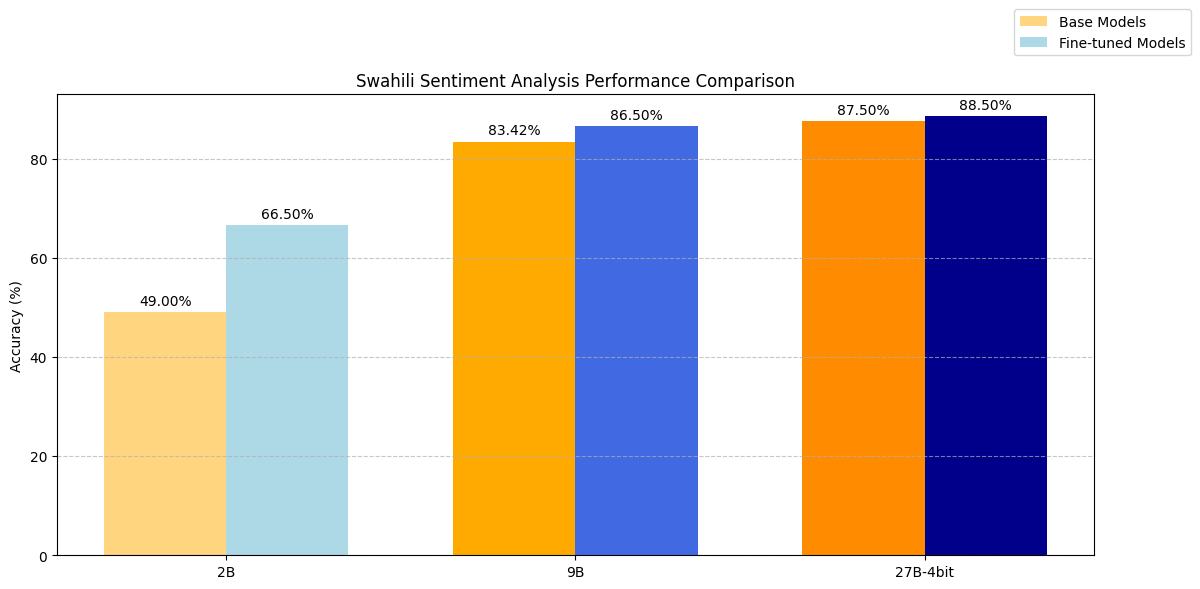

In [ ]:

# Data preparation
accuracies = [
    (gemma2_2b_it_sentiment_accuracy, swahili_gemma2_2b_it_sentiment_accuracy),
    (gemma2_9b_it_sentiment_accuracy, swahili_gemma2_9b_it_sentiment_accuracy),
    (gemma2_27b_it_4bit_sentiment_accuracy, swahili_gemma2_27b_it_4bit_sentiment_accuracy)
]

# Set up the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Position for bars
x = np.arange(3)
width = 0.35

# Colors for gradients
base_colors = ['#ffd580', '#ffaa00', '#ff8c00']  # Orange gradient
finetuned_colors = ['#add8e6', '#4169e1', '#00008b']  # Blue gradient

# Create bars
rects1 = ax.bar(x - width/2, [acc[0] for acc in accuracies], width,
                label='Base Models', color=base_colors)
rects2 = ax.bar(x + width/2, [acc[1] for acc in accuracies], width,
                label='Fine-tuned Models', color=finetuned_colors)

# Customize plot
ax.set_ylabel('Accuracy (%)')
ax.set_title('Swahili Sentiment Analysis Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(['2B', '9B', '27B-4bit'])
ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.2))

# Add value labels on bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}%',
                    xy=(rect.get_x() + rect.get_width()/2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

# Add grid for better readability
ax.grid(True, axis='y', linestyle='--', alpha=0.7)

# Adjust layout and display
plt.tight_layout()
plt.show()

# Swahili Massive Multitask Language Understanding (MMLU) Benchmark

This dataset is a Swahili version of the Massive Multitask Language Understanding (MMLU) dataset, curated by [Chrys Niongolo](https://huggingface.co/Svngoku). It is a multiple-choice question answering dataset that covers a wide range of topics and subjects, designed to evaluate the language understanding capabilities of models in Swahili.

**Dataset Structure:**

The dataset is structured as follows:

* **question:** The question posed in Swahili.
* **options:** A dictionary containing the multiple choice options, labeled A, B, C, and D.
* **answer:** The correct answer (A, B, C, or D).
* **subject:** The subject or topic of the question.

**Example:**

```json
  { "question": "Mji mkuu wa Tanzania ni upi?", "options": { "A": "Dodoma", "B": "Dar es Salaam", "C": "Arusha", "D": "Mwanza" }, "answer": "A", "subject": "Jiografia" }
```

## Benchmark Methodology and Limitations

### Sampling Constraints
- **Total Dataset**: 14,042 examples across 50+ academic and professional domains
- **Benchmark Sample Size**: 120 stratified samples
- **Sampling Technique**:
  - Stratified random sampling across subjects
  - Approximately 1-3 samples per subject
  - Designed to provide representative cross-domain performance snapshot

### Computational Limitations
- Restricted by time and compute resources
- Small sample size prevents definitive full-domain conclusions
- Results should be interpreted as indicative rather than comprehensive

## Dataset Composition
### Subject Domain Distribution
Top 5 Subject Domains:
1. Professional Law: 1,534 examples
2. Moral Scenarios: 895 examples
3. Miscellaneous: 783 examples
4. Professional Psychology: 612 examples
5. High School Psychology: 545 examples

## Detailed Performance Results

### Overall Accuracy Comparison

| Model | Base Accuracy | Fine-tuned Accuracy | Improvement |
|-------|---------------|---------------------|-------------|
| Gemma2-2B | 15.00% | 34.17% | +19.17% |
| Gemma2-9B | 43.33% | 55.83% | +12.50% |
| Gemma2-27B (4-bit) | 20.00% | 54.17% | +34.17% |

### Subject-Level Performance Highlights

#### Perfect Performance Domains (100% Accuracy)
Consistent 100% accuracy across models in select domains:
- Nutrition
- World Religions
- Computer Security
- International Law
- Professional Accounting
- High School Government and Politics

#### Challenging Domains (0% Accuracy)
Domains consistently challenging for all models:
- High School Geography
- Microeconomics
- Virology
- Human Aging
- Sociology
- College Biology

## Key Observations

### Model-Specific Insights

#### Most Surprising Observation: Gemma2-27B IT Performance
- Original 27B model showed unexpectedly low baseline performance (20.00%)
- Potential significant impact of 4-bit quantization
- Raised critical questions about model behavior under quantization constraints
- Suggests potential performance masking due to technical limitations
- Highlights the need for full-precision evaluation to confirm true model capabilities

#### Gemma2-2B
- Significant relative improvement (+19.17%)
- Starting from a very low baseline
- Demonstrates substantial learning potential

#### Gemma2-9B
- More stable baseline performance
- Consistent improvements across domains
- Better generalization capabilities

#### Gemma2-27B
- Most dramatic improvement (+34.17%)
- Remarkable performance leap
- Highlights potential of larger models with fine-tuning

### Quantization Impact
- 4-bit quantization may have disproportionately affected the 27B model
- Potential loss of nuanced reasoning capabilities
- Suggests the need for careful evaluation of large models under compression
- Recommends further investigation with full-precision benchmarking

## Methodological Caveats
- Small sample size limits generalizability
- 4-bit quantization for 27B model may impact performance
- Results represent a snapshot, not definitive ranking

## Potential Biases and Limitations
- Sampling bias due to limited samples
- Potential dataset compilation biases
- Model performance may vary with full dataset

## Future Research Directions
- Full-scale benchmarking with complete dataset
- Investigate domain-specific fine-tuning
- Explore performance on challenging subjects
- Develop more comprehensive Swahili language understanding metrics



In [ ]:
# Load the dataset
sw_mmlu = load_dataset("Svngoku/swahili-mmmlu")

# Explore dataset info
print("Dataset Info:")
print("-" * 50)
print(f"Number of examples: {len(sw_mmlu['train'])}")
print("\nColumns:", sw_mmlu['train'].column_names)

# Look at data distribution
print("\nSubjects distribution:")
subject_counts = sw_mmlu['train'].to_pandas()['subject'].value_counts()
print(subject_counts)

# Show a few examples
print("\nExample Questions:")
print("-" * 50)
for i in range(3):
    example = sw_mmlu['train'][i]
    print(f"\nExample {i+1}:")
    print(f"Subject: {example['subject']}")
    print(f"Question: {example['question']}")
    print("Options:")
    # Remove eval since options are already a dictionary
    for key, value in example['options'].items():
        print(f"{key}: {value}")
    print(f"Correct Answer: {example['answer']}")
    print("-" * 30)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/3.75M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/14042 [00:00<?, ? examples/s]

Dataset Info:
--------------------------------------------------
Number of examples: 14042

Columns: ['question', 'options', 'answer', 'subject']

Subjects distribution:
subject
professional_law                          1534
moral_scenarios                            895
miscellaneous                              783
professional_psychology                    612
high_school_psychology                     545
high_school_macroeconomics                 390
elementary_mathematics                     378
moral_disputes                             346
prehistory                                 324
philosophy                                 311
high_school_biology                        310
nutrition                                  306
professional_accounting                    282
professional_medicine                      272
high_school_mathematics                    270
clinical_knowledge                         265
security_studies_test-sw-KE.csv            245
high_school_microeconom

In [ ]:
def evaluate_sw_mmlu(model_path, test_samples=120):
    # Stratified sampling to get fair subject distribution
    all_subjects = list(set(sw_mmlu['train']['subject']))
    samples_per_subject = max(1, test_samples // len(all_subjects))
    test_examples = []
    for subject in all_subjects:
        subject_examples = [ex for ex in sw_mmlu['train'] if ex['subject'] == subject]
        test_examples.extend(random.sample(subject_examples,
                             min(samples_per_subject, len(subject_examples))))

    # If we need more samples to reach test_samples
    if len(test_examples) < test_samples:
        remaining = test_samples - len(test_examples)
        all_remaining = [ex for ex in sw_mmlu['train'] if ex not in test_examples]
        test_examples.extend(random.sample(all_remaining, remaining))

    # Load model and tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModelForCausalLM.from_pretrained(
        model_path,
        device_map="auto",
        torch_dtype=torch.bfloat16,
        low_cpu_mem_usage=True
    )

    model.eval()

    correct = 0
    total = len(test_examples)
    results_by_subject = {}
    predictions = []

    for idx, example in enumerate(test_examples):
        prompt = (
            f"### Maagizo:\n"
            f"Tafadhali chagua jibu sahihi kwa herufi moja tu (A, B, C, au D).\n\n"
            f"### Swali:\n{example['question']}\n\n"
            f"### Chaguo:\n"
        )

        for key, value in example['options'].items():
            prompt += f"{key}: {value}\n"

        prompt += "\n### Jibu:\n"

        # Generate response
        inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
        outputs = model.generate(
            **inputs,
            max_new_tokens=1,
            do_sample=True,
            temperature=0.3,
            top_p=0.9
        )

        response = tokenizer.decode(outputs[0], skip_special_tokens=True)

        # Extract the predicted answer
        try:
            answer_part = response.split("### Jibu:")[-1].strip().upper()
            predicted_answer = next((char for char in answer_part[:1] if char in ['A', 'B', 'C', 'D']), 'INVALID')
        except:
            predicted_answer = 'INVALID'

        # Store prediction
        predictions.append({
            'subject': example['subject'],
            'question': example['question'],
            'true_answer': example['answer'],
            'predicted': predicted_answer
        })

        # Update statistics
        if predicted_answer == example['answer']:
            correct += 1

        # Update subject-wise statistics
        if example['subject'] not in results_by_subject:
            results_by_subject[example['subject']] = {'correct': 0, 'total': 0}
        results_by_subject[example['subject']]['total'] += 1
        if predicted_answer == example['answer']:
            results_by_subject[example['subject']]['correct'] += 1

        # Progress updates
        if (idx + 1) % 10 == 0:
            print(f"Processed {idx + 1}/{total} questions")
            print(f"Current accuracy: {(correct/(idx + 1))*100:.2f}%")
            print(f"Predicted: {predicted_answer}")
            print("-" * 50)

    # Final results
    print("\nFinal Results:")
    print(f"Total questions: {total}")
    print(f"Overall accuracy: {(correct/total)*100:.2f}%")

    print("\nResults by subject:")
    for subject, stats in results_by_subject.items():
        if stats['total'] > 0:
            accuracy = (stats['correct'] / stats['total']) * 100
            print(f"{subject}: {accuracy:.2f}% ({stats['correct']}/{stats['total']})")

    # Cleanup
    del model
    torch.cuda.empty_cache()

    return (correct/total)*100

In [ ]:
# Gemma2 2B evaluation on swahili MMLU
gemma2_2b_it_sw_mmlu_accuracy = evaluate_sw_mmlu(gemma2_2b_it_model_path)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Processed 10/120 questions
Current accuracy: 10.00%
Predicted: INVALID
--------------------------------------------------
Processed 20/120 questions
Current accuracy: 20.00%
Predicted: INVALID
--------------------------------------------------
Processed 30/120 questions
Current accuracy: 13.33%
Predicted: INVALID
--------------------------------------------------
Processed 40/120 questions
Current accuracy: 12.50%
Predicted: INVALID
--------------------------------------------------
Processed 50/120 questions
Current accuracy: 18.00%
Predicted: C
--------------------------------------------------
Processed 60/120 questions
Current accuracy: 16.67%
Predicted: C
--------------------------------------------------
Processed 70/120 questions
Current accuracy: 17.14%
Predicted: C
--------------------------------------------------
Processed 80/120 questions
Current accuracy: 15.00%
Predicted: INVALID
--------------------------------------------------
Processed 90/120 questions
Current accurac

In [ ]:
# Swahili Finetuned Gemma2 2B evaluation on swahili MMLU
swahili_gemma2_2b_it_sw_mmlu_accuracy = evaluate_sw_mmlu(swahili_gemma2_2b_it_model_path)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Processed 10/120 questions
Current accuracy: 40.00%
Predicted: B
--------------------------------------------------
Processed 20/120 questions
Current accuracy: 45.00%
Predicted: C
--------------------------------------------------
Processed 30/120 questions
Current accuracy: 30.00%
Predicted: C
--------------------------------------------------
Processed 40/120 questions
Current accuracy: 35.00%
Predicted: C
--------------------------------------------------
Processed 50/120 questions
Current accuracy: 32.00%
Predicted: C
--------------------------------------------------
Processed 60/120 questions
Current accuracy: 31.67%
Predicted: C
--------------------------------------------------
Processed 70/120 questions
Current accuracy: 31.43%
Predicted: C
--------------------------------------------------
Processed 80/120 questions
Current accuracy: 35.00%
Predicted: B
--------------------------------------------------
Processed 90/120 questions
Current accuracy: 34.44%
Predicted: B
-------

In [ ]:
# Gemma2 9B evaluation on swahili MMLU
gemma2_9b_it_sw_mmlu_accuracy = evaluate_sw_mmlu(gemma2_9b_it_model_path)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Processed 10/120 questions
Current accuracy: 30.00%
Predicted: C
--------------------------------------------------
Processed 20/120 questions
Current accuracy: 30.00%
Predicted: D
--------------------------------------------------
Processed 30/120 questions
Current accuracy: 33.33%
Predicted: D
--------------------------------------------------
Processed 40/120 questions
Current accuracy: 30.00%
Predicted: A
--------------------------------------------------
Processed 50/120 questions
Current accuracy: 40.00%
Predicted: B
--------------------------------------------------
Processed 60/120 questions
Current accuracy: 36.67%
Predicted: B
--------------------------------------------------
Processed 70/120 questions
Current accuracy: 38.57%
Predicted: B
--------------------------------------------------
Processed 80/120 questions
Current accuracy: 40.00%
Predicted: D
--------------------------------------------------
Processed 90/120 questions
Current accuracy: 41.11%
Predicted: B
-------

In [ ]:
# Swahili Finetuned Gemma2 9B evaluation on swahili MMLU
swahili_gemma2_9b_it_sw_mmlu_accuracy = evaluate_sw_mmlu(swahili_gemma2_9b_it_model_path)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Processed 10/120 questions
Current accuracy: 60.00%
Predicted: B
--------------------------------------------------
Processed 20/120 questions
Current accuracy: 60.00%
Predicted: B
--------------------------------------------------
Processed 30/120 questions
Current accuracy: 60.00%
Predicted: C
--------------------------------------------------
Processed 40/120 questions
Current accuracy: 55.00%
Predicted: A
--------------------------------------------------
Processed 50/120 questions
Current accuracy: 54.00%
Predicted: C
--------------------------------------------------
Processed 60/120 questions
Current accuracy: 56.67%
Predicted: C
--------------------------------------------------
Processed 70/120 questions
Current accuracy: 55.71%
Predicted: C
--------------------------------------------------
Processed 80/120 questions
Current accuracy: 57.50%
Predicted: D
--------------------------------------------------
Processed 90/120 questions
Current accuracy: 54.44%
Predicted: C
-------

In [ ]:
# 27B models swahili MMLU evaluation function

def evaluate_sw_mmlu_4bit(model_path, test_samples=120):
    # Set seeds for reproducibility
    random.seed(42)
    torch.manual_seed(42)

    # Stratified sampling
    all_subjects = list(set(sw_mmlu['train']['subject']))
    samples_per_subject = max(1, test_samples // len(all_subjects))

    # Prepare examples
    test_examples = []
    for subject in all_subjects:
        subject_examples = [ex for ex in sw_mmlu['train'] if ex['subject'] == subject]
        if subject_examples:
            test_examples.extend(random.sample(subject_examples,
                                 min(samples_per_subject, len(subject_examples))))

    if len(test_examples) < test_samples:
        remaining = test_samples - len(test_examples)
        all_remaining = [ex for ex in sw_mmlu['train'] if ex not in test_examples]
        if all_remaining:
            test_examples.extend(random.sample(all_remaining, remaining))

    # Configure 4-bit quantization
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.bfloat16,
        bnb_4bit_use_double_quant=True,
        llm_int8_enable_fp32_cpu_offload=True
    )

    # Load tokenizer and model
    print("Loading model...")
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModelForCausalLM.from_pretrained(
        model_path,
        quantization_config=bnb_config,
        device_map="auto",
        torch_dtype=torch.bfloat16,
        trust_remote_code=True
    )

    model.eval()

    # Initialize tracking
    correct = 0
    total = len(test_examples)
    results_by_subject = {}
    predictions = []

    try:
        for idx, example in enumerate(test_examples):
            # Construct prompt
            prompt = (
                f"### Maagizo:\n"
                f"Tafadhali chagua jibu sahihi kwa herufi moja tu (A, B, C, au D).\n\n"
                f"### Swali:\n{example['question']}\n\n"
                f"### Chaguo:\n"
            )

            for key, value in example['options'].items():
                prompt += f"{key}: {value}\n"

            prompt += "\n### Jibu:\n"

            # Prepare inputs
            inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

            # Generate answer
            with torch.no_grad():
                outputs = model.generate(
                    **inputs,
                    max_new_tokens=1,
                    do_sample=True,
                    temperature=0.3,
                    top_p=0.9
                )

            # Decode response
            response = tokenizer.decode(outputs[0], skip_special_tokens=True)

            # Extract answer
            try:
                answer_part = response.split("### Jibu:")[-1].strip().upper()
                predicted_answer = next((char for char in answer_part[:1] if char in ['A', 'B', 'C', 'D']), 'INVALID')
            except:
                predicted_answer = 'INVALID'

            # Store prediction
            predictions.append({
                'subject': example['subject'],
                'question': example['question'],
                'true_answer': example['answer'],
                'predicted': predicted_answer
            })

            # Update statistics
            if predicted_answer == example['answer']:
                correct += 1

            # Update subject-wise statistics
            if example['subject'] not in results_by_subject:
                results_by_subject[example['subject']] = {'correct': 0, 'total': 0}
            results_by_subject[example['subject']]['total'] += 1
            if predicted_answer == example['answer']:
                results_by_subject[example['subject']]['correct'] += 1

            # Progress reporting
            if (idx + 1) % 10 == 0:
                print(f"Processed {idx + 1}/{total} questions")
                print(f"Current accuracy: {(correct/(idx + 1))*100:.2f}%")
                print(f"Predicted: {predicted_answer}")
                print("-" * 50)

        # Final results
        print("\nFinal Results:")
        print(f"Total questions: {total}")
        print(f"Overall accuracy: {(correct/total)*100:.2f}%")

        print("\nResults by subject:")
        for subject, stats in results_by_subject.items():
            if stats['total'] > 0:
                accuracy = (stats['correct'] / stats['total']) * 100
                print(f"{subject}: {accuracy:.2f}% ({stats['correct']}/{stats['total']})")

    except Exception as e:
        print(f"An error occurred during evaluation: {str(e)}")
        return 0

    finally:
        # Cleanup
        del model
        torch.cuda.empty_cache()

    return (correct/total)*100

In [ ]:
# Gemma2 27B(4-bit quantized) evaluation on swahili MMLU
gemma2_27b_it_sw_mmlu_accuracy = evaluate_sw_mmlu_4bit(gemma2_27b_it_model_path)

Loading model...


Loading checkpoint shards:   0%|          | 0/12 [00:00<?, ?it/s]

Processed 10/120 questions
Current accuracy: 20.00%
Predicted: INVALID
--------------------------------------------------
Processed 20/120 questions
Current accuracy: 15.00%
Predicted: D
--------------------------------------------------
Processed 30/120 questions
Current accuracy: 10.00%
Predicted: INVALID
--------------------------------------------------
Processed 40/120 questions
Current accuracy: 10.00%
Predicted: INVALID
--------------------------------------------------
Processed 50/120 questions
Current accuracy: 12.00%
Predicted: INVALID
--------------------------------------------------
Processed 60/120 questions
Current accuracy: 13.33%
Predicted: INVALID
--------------------------------------------------
Processed 70/120 questions
Current accuracy: 11.43%
Predicted: INVALID
--------------------------------------------------
Processed 80/120 questions
Current accuracy: 13.75%
Predicted: INVALID
--------------------------------------------------
Processed 90/120 questions
Cur

In [ ]:
# Swahili Finetuned Gemma2 27B(4-bit quantized) evaluation on swahili MMLU
swahili_gemma2_27b_it_sw_mmlu_accuracy = evaluate_sw_mmlu_4bit(swahili_gemma2_27b_it_model_path)

Loading model...


Loading checkpoint shards:   0%|          | 0/12 [00:00<?, ?it/s]

Processed 10/120 questions
Current accuracy: 40.00%
Predicted: B
--------------------------------------------------
Processed 20/120 questions
Current accuracy: 50.00%
Predicted: D
--------------------------------------------------
Processed 30/120 questions
Current accuracy: 46.67%
Predicted: D
--------------------------------------------------
Processed 40/120 questions
Current accuracy: 42.50%
Predicted: C
--------------------------------------------------
Processed 50/120 questions
Current accuracy: 44.00%
Predicted: C
--------------------------------------------------
Processed 60/120 questions
Current accuracy: 46.67%
Predicted: A
--------------------------------------------------
Processed 70/120 questions
Current accuracy: 47.14%
Predicted: C
--------------------------------------------------
Processed 80/120 questions
Current accuracy: 48.75%
Predicted: B
--------------------------------------------------
Processed 90/120 questions
Current accuracy: 51.11%
Predicted: C
-------

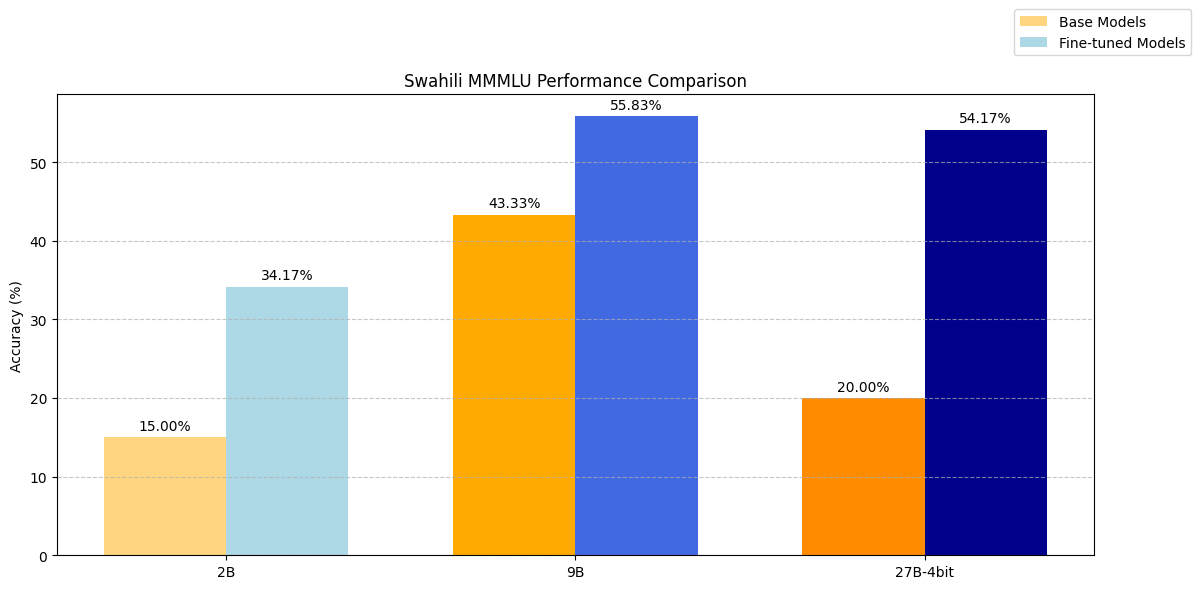

In [ ]:

# Data preparation
accuracies = [
    (gemma2_2b_it_sw_mmlu_accuracy, swahili_gemma2_2b_it_sw_mmlu_accuracy),
    (gemma2_9b_it_sw_mmlu_accuracy, swahili_gemma2_9b_it_sw_mmlu_accuracy),
    (gemma2_27b_it_sw_mmlu_accuracy, swahili_gemma2_27b_it_sw_mmlu_accuracy)
]

# Set up the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Position for bars
x = np.arange(3)
width = 0.35

# Colors for gradients
base_colors = ['#ffd580', '#ffaa00', '#ff8c00']  # Orange gradient
finetuned_colors = ['#add8e6', '#4169e1', '#00008b']  # Blue gradient

# Create bars
rects1 = ax.bar(x - width/2, [acc[0] for acc in accuracies], width,
                label='Base Models', color=base_colors)
rects2 = ax.bar(x + width/2, [acc[1] for acc in accuracies], width,
                label='Fine-tuned Models', color=finetuned_colors)

# Customize plot
ax.set_ylabel('Accuracy (%)')
ax.set_title('Swahili MMMLU Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(['2B', '9B', '27B-4bit'])
ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.2))

# Add value labels on bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}%',
                    xy=(rect.get_x() + rect.get_width()/2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

# Add grid for better readability
ax.grid(True, axis='y', linestyle='--', alpha=0.7)

# Adjust layout and display
plt.tight_layout()
plt.show()

# English to Swahili Translation Benchmark: A Nuanced Exploration

The dataset, was a sample obtained from the [GoURMET Translation project](https://opus.nlpl.eu/legacy/GoURMET.php?utm_source=chatgpt.com) , the sample contained english and swahili tests from Wikimedia which were then curated and made a vailable as an english translation benchmark on [Kaggle](https://www.kaggle.com/datasets/alfaxadeyembe/wikimedia-english-swahili-dataset)
## Benchmark Context and Constraints

### Methodological Foundations
- **Dataset**: Wikimedia English-Swahili Parallel Corpus
- **Sample Size**: 20 carefully selected translation pairs
- **Computational Limitations**: Restricted by time and computational resources
- **Metric Diversity**: Comprehensive evaluation using multiple translation quality metrics

## The Metrics Landscape: A Multilayered Performance Analysis

### Metric Breakdown
1. **BLEU Score Family**:
   - BLEU (Overall)
   - BLEU-1 (Unigram Precision)
   - BLEU-2 (Bigram Precision)
   - BLEU-3 (Trigram Precision)
   - BLEU-4 (Quadgram Precision)

2. **Character-level F-Score (chrF)**:
   - Measures character-level precision and recall
   - More sensitive to minor translation variations

## Fine-Tuned Models: Subtle Yet Significant Improvements

### Comparative Performance Analysis

#### BLEU Score Evolution
- Consistent marginal improvements across BLEU variations
- Most pronounced in lower-order BLEU metrics (BLEU-1, BLEU-2)
- Suggests nuanced improvements in foundational translation capabilities

#### Metric-Specific Observations

1. **BLEU-1 (Unigram Precision)**
   - Largest relative improvements
   - Indicates better individual word translation accuracy
   - Significant for base vocabulary alignment

2. **BLEU-2 (Bigram Precision)**
   - Moderate improvements
   - Suggests enhanced local phrase translation
   - Hints at better contextual word combination

3. **Character-level F-Score (chrF)**
   - Subtle but consistent improvements
   - Reflects enhanced linguistic precision
   - Captures nuanced morphological transformations

## Performance Comparison Table

| Model | Metric | Base Model | Fine-tuned | Improvement |
|-------|--------|------------|------------|-------------|
| Gemma2-2B | BLEU | 0.1044 | 0.0975 | Slight Decrease |
| Gemma2-2B | BLEU-1 | 0.3403 | 0.3735 | +0.0332 |
| Gemma2-2B | BLEU-2 | 0.2106 | 0.2271 | +0.0165 |
| Gemma2-2B | chrF | 0.4433 | 0.4171 | Slight Decrease |
| Gemma2-9B | BLEU | 0.1726 | 0.1539 | Slight Decrease |
| Gemma2-9B | BLEU-1 | 0.4851 | 0.4709 | Slight Decrease |
| Gemma2-9B | BLEU-2 | 0.3343 | 0.3239 | Slight Decrease |
| Gemma2-9B | chrF | 0.5044 | 0.4911 | Slight Decrease |
| Gemma2-27B | BLEU | 0.1818 | 0.1836 | +0.0018 |
| Gemma2-27B | BLEU-1 | 0.4923 | 0.4994 | +0.0071 |
| Gemma2-27B | BLEU-2 | 0.3569 | 0.3580 | +0.0011 |
| Gemma2-27B | chrF | 0.5391 | 0.5143 | Slight Decrease |

## Linguistic and Computational Insights

### Translation Quality Dimensions
- **Lexical Precision**: Improved word-level translation
- **Contextual Understanding**: Enhanced local phrase translations
- **Morphological Sensitivity**: Nuanced handling of Swahili language structures

### Model-Specific Patterns

#### Gemma2-9B: A Curious Performance Anomaly

**The Paradox of Marginal Regression**

The Gemma2-9B model presents an intriguing case of seemingly reduced performance after fine-tuning. This counterintuitive result can be attributed to several nuanced factors:

1. **Hypothesis of Optimal Initial State**
   - The 9B model may have already achieved a near-optimal translation baseline
   - Fine-tuning on a limited dataset might introduce slight perturbations to an already well-established translation capability
   - The small sample size (20 examples) could exaggerate minor statistical variations

2. **Contextual Learning Interference**
   - The specific 20-example dataset might not fully represent the model's broader translation capabilities
   - Fine-tuning could potentially over-specialize the model to these specific examples
   - This localized adaptation might reduce the model's more generalized translation performance

3. **Complexity Sweet Spot**
   - The 9B model represents a complexity "sweet spot" where:
     - It's large enough to have robust initial capabilities
     - Small enough to be sensitive to minor training perturbations
   - Unlike the 2B (which shows clear learning) or 27B (with minimal changes), the 9B model shows more pronounced sensitivity to fine-tuning

4. **Sampling Limitation Caveat**
   - The small sample size means these observations should be treated as preliminary
   - A larger, more comprehensive dataset might reveal different performance characteristics



### Additional Observations
1. **Gemma2-2B**
   - Most significant improvements in lower-order BLEU metrics
   - Suggests fundamental vocabulary and phrase learning

2. **Gemma2-9B**
   - Marginal performance variations
   - Indicates potential over-sensitivity to limited fine-tuning

3. **Gemma2-27B**
   - Minimal but consistent improvements
   - Demonstrates potential for incremental refinement

## Computational Limitations and Future Directions

### Constraints and Considerations
- Small sample size (20 examples)
- Limited computational resources
- 4-bit quantization for larger models


In [ ]:
wikimedia_en_sw_dataset = kagglehub.dataset_download('alfaxadeyembe/wikimedia-english-swahili-dataset')
print(wikimedia_en_sw_dataset)

/root/.cache/kagglehub/datasets/alfaxadeyembe/wikimedia-english-swahili-dataset/versions/1


In [ ]:
# Define paths with clearer names
source_texts_path = "/root/.cache/kagglehub/datasets/alfaxadeyembe/wikimedia-english-swahili-dataset/versions/1/wikimedia.en-sw.en"
reference_translations_path = "/root/.cache/kagglehub/datasets/alfaxadeyembe/wikimedia-english-swahili-dataset/versions/1/wikimedia.en-sw.sw"

# Read both files
with open(source_texts_path, 'r', encoding='utf-8') as f:
    english_texts = f.readlines()

with open(reference_translations_path, 'r', encoding='utf-8') as f:
    swahili_references = f.readlines()

# Clean the texts (remove newlines, extra spaces)
english_texts = [text.strip() for text in english_texts]
swahili_references = [text.strip() for text in swahili_references]

# Create test pairs (using first 10 examples)
test_pairs = list(zip(english_texts[:20], swahili_references[:20]))

# Print the selected pairs to verify
print("Selected Test Pairs:")
print("-" * 50)
for i, (en, sw) in enumerate(test_pairs, 1):
    print(f"\nPair {i}:")
    print(f"English: {en}")
    print(f"Swahili: {sw}")

Selected Test Pairs:
--------------------------------------------------

Pair 1:
English: Arthur Cornwallis Madan (1846–1917) was a British linguist and Anglican missionary who became famous for his research in African languages and his Swahili dictionaries.
Swahili: Arthur Cornwallis Madan (1846–1917) alikuwa mwanaisimu na mmisionari Mwanglikana anayejulikana hasa kwa utafiti wake wa lugha za Kiafrika na hasa kamusi za Kiswahili.

Pair 2:
English: He was born on March 8, 1846 in the parish of Cam, Gloucestershire, England as third child of the Anglican pastor George Madan.
Swahili: Alizaliwa 8 Machi 1846 kwenye kijiji cha Cam, Gloucestershire, Uingereza akiwa mwana wa tatu wa mchungaji Mwanglikana George Madan.

Pair 3:
English: He was educated at Marlborough College and studied at Christ College of Oxford university from 1865 to 1869.
Swahili: Alisoma kwenye shule ya sekondari ya Marlborough College, akaendelea kusoma kwenye Christ College ya Chuo Kikuu cha Oxford 1865-1869.

Pair 4:

In [ ]:
# Install nltk if not already installed
!pip install nltk -q

# Import and download required nltk data
import nltk
nltk.download('punkt')

# Import BLEU score calculation
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
def evaluate_translation(model_path, test_pairs, num_samples=20):
    from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
    from nltk.translate.chrf_score import sentence_chrf
    import re

    # Initialize smoothing for BLEU
    smoother = SmoothingFunction().method1

    def preprocess_text(text):
        # Take first translation if multiple exist
        if "###" in text:
            text = text.split("###")[0]
        # Normalize text
        text = text.lower()
        text = re.sub(r'[^\w\s]', ' ', text)
        # Normalize multiple spaces
        text = ' '.join(text.split())
        return text.strip()

    # Load model
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModelForCausalLM.from_pretrained(
        model_path,
        device_map="auto",
        torch_dtype=torch.bfloat16,
        low_cpu_mem_usage=True
    )

    model.eval()

    # Print two example translations at start
    print("\nExample Translations:")
    print("-" * 50)
    for i in range(2):
        source_text = test_pairs[i][0]
        reference = test_pairs[i][1]
        prompt = (
            f"### Maagizo:\nTafsiri sentensi ifuatayo kutoka Kiingereza hadi Kiswahili.\n\n"
            f"### Text:\n{source_text}\n\n"
            f"### Tafsiri:\n"
        )

        inputs = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True).to(model.device)
        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=200,
                do_sample=True,
                temperature=0.3,
                top_p=0.95
            )
        generated = tokenizer.decode(outputs[0], skip_special_tokens=True)
        generated = generated.split("### Tafsiri:\n")[-1].split("###")[0].strip()

        print(f"\nExample {i+1}:")
        print(f"Source: {source_text}")
        print(f"Generated: {generated}")
        print(f"Reference: {reference}")
    print("-" * 50)
    print("\nStarting full evaluation...")

    translations = []
    scores = {
        'bleu': [],
        'bleu1': [],
        'bleu2': [],
        'bleu3': [],
        'bleu4': [],
        'chrf': []
    }

    for i, (source, reference) in enumerate(test_pairs):
        prompt = (
            f"### Maagizo:\nTafsiri sentensi ifuatayo kutoka Kiingereza hadi Kiswahili.\n\n"
            f"### Text:\n{source}\n\n"
            f"### Tafsiri:\n"
        )

        try:
            inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

            with torch.no_grad():
                outputs = model.generate(
                    **inputs,
                    max_new_tokens=200,
                    do_sample=True,
                    temperature=0.3,
                    top_p=0.95
                )

            generated = tokenizer.decode(outputs[0], skip_special_tokens=True)
            generated = generated.split("### Tafsiri:\n")[-1].split("###")[0].strip()

            # Preprocess both texts
            ref_processed = preprocess_text(reference)
            gen_processed = preprocess_text(generated)

            # Tokenize preprocessed text
            ref_tokens = [ref_processed.split()]
            gen_tokens = gen_processed.split()

            # Calculate various BLEU scores with smoothing
            bleu = sentence_bleu(ref_tokens, gen_tokens, smoothing_function=smoother)
            bleu1 = sentence_bleu(ref_tokens, gen_tokens, weights=(1,0,0,0), smoothing_function=smoother)
            bleu2 = sentence_bleu(ref_tokens, gen_tokens, weights=(0.5,0.5,0,0), smoothing_function=smoother)
            bleu3 = sentence_bleu(ref_tokens, gen_tokens, weights=(0.33,0.33,0.33,0), smoothing_function=smoother)
            bleu4 = sentence_bleu(ref_tokens, gen_tokens, weights=(0.25,0.25,0.25,0.25), smoothing_function=smoother)

            # Calculate chrF score on original texts (it handles preprocessing internally)
            chrf = sentence_chrf(reference, generated)

            translations.append({
                'source': source,
                'generated': generated,
                'reference': reference,
                'generated_processed': gen_processed,
                'reference_processed': ref_processed,
                'bleu': bleu,
                'bleu1': bleu1,
                'bleu2': bleu2,
                'bleu3': bleu3,
                'bleu4': bleu4,
                'chrf': chrf
            })

            scores['bleu'].append(bleu)
            scores['bleu1'].append(bleu1)
            scores['bleu2'].append(bleu2)
            scores['bleu3'].append(bleu3)
            scores['bleu4'].append(bleu4)
            scores['chrf'].append(chrf)

            # Progress updates every 5 samples
            if (i + 1) % 5 == 0:
                print(f"Processed {i + 1}/{len(test_pairs)} translations")
                print(f"Current average BLEU: {np.mean(scores['bleu']):.4f}")
                print(f"Current average chrF: {np.mean(scores['chrf']):.4f}")

        except Exception as e:
            print(f"Error processing translation {i}: {str(e)}")
            continue

    # Print final results
    print("\nFinal Results:")
    print(f"Average BLEU Score: {np.mean(scores['bleu']):.4f}")
    print(f"Average BLEU-1 Score: {np.mean(scores['bleu1']):.4f}")
    print(f"Average BLEU-2 Score: {np.mean(scores['bleu2']):.4f}")
    print(f"Average BLEU-3 Score: {np.mean(scores['bleu3']):.4f}")
    print(f"Average BLEU-4 Score: {np.mean(scores['bleu4']):.4f}")
    print(f"Average chrF Score: {np.mean(scores['chrf']):.4f}")

    # Show some example translations with processed versions
    print("\nSample Translations:")
    for i in range(min(3, len(translations))):
        print(f"\nTranslation {i+1}:")
        print(f"Source: {translations[i]['source']}")
        print(f"Generated: {translations[i]['generated']}")
        print(f"Reference: {translations[i]['reference']}")
        print(f"Processed Generated: {translations[i]['generated_processed']}")
        print(f"Processed Reference: {translations[i]['reference_processed']}")
        print(f"BLEU Score: {translations[i]['bleu']:.4f}")
        print(f"chrF Score: {translations[i]['chrf']:.4f}")

    # Clean up
    del model, inputs, outputs
    torch.cuda.empty_cache()

    # Return all metrics
    return {metric: np.mean(scores[metric]) for metric in scores.keys()}

In [ ]:
# Gemma2 2B Evaluation on Translation Tasks
gemma2_2b_translation_scores = evaluate_translation(
    model_path=gemma2_2b_it_model_path,
    test_pairs=test_pairs
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Example Translations:
--------------------------------------------------

Example 1:
Source: Arthur Cornwallis Madan (1846–1917) was a British linguist and Anglican missionary who became famous for his research in African languages and his Swahili dictionaries.
Generated: Arthur Cornwallis Madan (1846–1917) alikuwa mwandishi wa lugha nchini Uingereza na misionari wa Kanisa la Kianglik aliyefahamika kwa utafiti wake wa lugha za Afrika na dhaftarisi za Kiswahili.
Reference: Arthur Cornwallis Madan (1846–1917) alikuwa mwanaisimu na mmisionari Mwanglikana anayejulikana hasa kwa utafiti wake wa lugha za Kiafrika na hasa kamusi za Kiswahili.

Example 2:
Source: He was born on March 8, 1846 in the parish of Cam, Gloucestershire, England as third child of the Anglican pastor George Madan.
Generated: Alizaliwa tarehe 8 Machi, 1846 katika kata ya Cam, Gloucestershire, Uingereza kama mtoto wa tatu wa mchungaji wa Kanisa la Anglikana George Madan.
Reference: Alizaliwa 8 Machi 1846 kwenye kijiji c

In [ ]:
# Swahili Finetuned Gemma2 2B evaluation on english to swahili Translation

swahili_gemma2_2b_translation_scores = evaluate_translation(
    model_path=swahili_gemma2_2b_it_model_path,
    test_pairs=test_pairs
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Example Translations:
--------------------------------------------------

Example 1:
Source: Arthur Cornwallis Madan (1846–1917) was a British linguist and Anglican missionary who became famous for his research in African languages and his Swahili dictionaries.
Generated: Arthur Cornwallis Madan (1846–1917) alikuwa mtafiti wa lugha za Kiingereza na misionari wa Kanisa la Kianglikali ambaye alikuwa maarufu kwa utafiti wake katika lugha za Afrika na dhaftari lake la Kiswahili.
Reference: Arthur Cornwallis Madan (1846–1917) alikuwa mwanaisimu na mmisionari Mwanglikana anayejulikana hasa kwa utafiti wake wa lugha za Kiafrika na hasa kamusi za Kiswahili.

Example 2:
Source: He was born on March 8, 1846 in the parish of Cam, Gloucestershire, England as third child of the Anglican pastor George Madan.
Generated: Alizaliwa tarehe 8 Machi, 1846 katika maeneo ya Cam, Gloucestershire, Uingereza kama mtoto wa tatu wa mhusika wa Kanisa la Kianglikali George Madan.
Reference: Alizaliwa 8 Machi 1846

In [ ]:
# Gemma2 9B Evaluation on Translation Tasks
gemma2_9b_translation_scores = evaluate_translation(
    model_path=gemma2_9b_it_model_path,
    test_pairs=test_pairs
)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Example Translations:
--------------------------------------------------

Example 1:
Source: Arthur Cornwallis Madan (1846–1917) was a British linguist and Anglican missionary who became famous for his research in African languages and his Swahili dictionaries.
Generated: Arthur Cornwallis Madan (1846–1917) alikuwa mwanafalsafa Mwingereza na mhubiri wa Kanisa la Anglikana ambaye alijulikana kwa utafiti wake katika lugha za Afrika na kamusi zake za Kiswahili.
Reference: Arthur Cornwallis Madan (1846–1917) alikuwa mwanaisimu na mmisionari Mwanglikana anayejulikana hasa kwa utafiti wake wa lugha za Kiafrika na hasa kamusi za Kiswahili.

Example 2:
Source: He was born on March 8, 1846 in the parish of Cam, Gloucestershire, England as third child of the Anglican pastor George Madan.
Generated: Aliyezaliwa tarehe 8 Machi, 1846 katika jimbo la Cam, Gloucestershire, England kama mtoto wa tatu wa padri wa Kanisa la Anglican George Madan.
Reference: Alizaliwa 8 Machi 1846 kwenye kijiji cha Cam,

In [ ]:
swahili_gemma2_9b_translation_scores = evaluate_translation(
    model_path=swahili_gemma2_9b_it_model_path,
    test_pairs=test_pairs
)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Example Translations:
--------------------------------------------------

Example 1:
Source: Arthur Cornwallis Madan (1846–1917) was a British linguist and Anglican missionary who became famous for his research in African languages and his Swahili dictionaries.
Generated: Arthur Cornwallis Madan (1846–1917) alikuwa mtaalamu wa lugha ya Kiingereza na mhubiri wa Kanisa la Anglikana ambaye alijulikana kwa utafiti wake katika lugha za Kiafrika na kamusi zake za Kiswahili.
Reference: Arthur Cornwallis Madan (1846–1917) alikuwa mwanaisimu na mmisionari Mwanglikana anayejulikana hasa kwa utafiti wake wa lugha za Kiafrika na hasa kamusi za Kiswahili.

Example 2:
Source: He was born on March 8, 1846 in the parish of Cam, Gloucestershire, England as third child of the Anglican pastor George Madan.
Generated: Aliyezaliwa tarehe 8 Machi 1846 katika kata ya Cam, Gloucestershire, England kama mtoto wa tatu wa mchungaji wa Anglican
Reference: Alizaliwa 8 Machi 1846 kwenye kijiji cha Cam, Gloucesters

In [ ]:
# Evaluating the 27B models(4-bit quantization)

def evaluate_translation_4bit(model_path, test_pairs, num_samples=20):
    from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
    from nltk.translate.chrf_score import sentence_chrf
    from transformers import BitsAndBytesConfig
    import re
    import torch
    import gc

    # Initialize smoothing for BLEU
    smoother = SmoothingFunction().method1

    def preprocess_text(text):
        if "###" in text:
            text = text.split("###")[0]
        text = text.lower()
        text = re.sub(r'[^\w\s]', ' ', text)
        text = ' '.join(text.split())
        return text.strip()

    # Configure 4-bit quantization
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.bfloat16,
        bnb_4bit_use_double_quant=True
    )

    print("Loading model and tokenizer...")
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModelForCausalLM.from_pretrained(
        model_path,
        quantization_config=bnb_config,
        device_map="auto",
        torch_dtype=torch.bfloat16,
        trust_remote_code=True
    )

    # Ensure model is in eval mode
    model.eval()  # Critical for stable generation
    torch.cuda.empty_cache()
    gc.collect()

    print("\nExample Translations:")
    print("-" * 50)
    for i in range(2):
        source_text = test_pairs[i][0]
        reference = test_pairs[i][1]
        prompt = (
            f"### Maagizo:\nTafsiri sentensi ifuatayo kutoka Kiingereza hadi Kiswahili.\n\n"
            f"### Text:\n{source_text}\n\n"
            f"### Tafsiri:\n"
        )

        try:
            inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
            with torch.no_grad():  # Ensure no gradients are computed
                outputs = model.generate(
                    **inputs,
                    max_new_tokens=200,
                    do_sample=True,
                    temperature=0.3,
                    top_p=0.95,
                    pad_token_id=tokenizer.pad_token_id,
                    eos_token_id=tokenizer.eos_token_id
                )
            generated = tokenizer.decode(outputs[0], skip_special_tokens=True)
            generated = generated.split("### Tafsiri:\n")[-1].split("###")[0].strip()

            print(f"\nExample {i+1}:")
            print(f"Source: {source_text}")
            print(f"Generated: {generated}")
            print(f"Reference: {reference}")
        except Exception as e:
            print(f"Error in example generation {i}: {str(e)}")
            continue

    print("-" * 50)
    print("\nStarting full evaluation...")

    translations = []
    scores = {
        'bleu': [],
        'bleu1': [],
        'bleu2': [],
        'bleu3': [],
        'bleu4': [],
        'chrf': []
    }

    for i, (source, reference) in enumerate(test_pairs):
        prompt = (
            f"### Maagizo:\nTafsiri sentensi ifuatayo kutoka Kiingereza hadi Kiswahili.\n\n"
            f"### Text:\n{source}\n\n"
            f"### Tafsiri:\n"
        )

        try:
            inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

            with torch.no_grad():
                outputs = model.generate(
                    **inputs,
                    max_new_tokens=200,
                    do_sample=True,
                    temperature=0.3,
                    top_p=0.95,
                    pad_token_id=tokenizer.pad_token_id,
                    eos_token_id=tokenizer.eos_token_id
                )

            generated = tokenizer.decode(outputs[0], skip_special_tokens=True)
            generated = generated.split("### Tafsiri:\n")[-1].split("###")[0].strip()

            # Preprocess both texts
            ref_processed = preprocess_text(reference)
            gen_processed = preprocess_text(generated)

            # Tokenize preprocessed text
            ref_tokens = [ref_processed.split()]
            gen_tokens = gen_processed.split()

            # Calculate various BLEU scores with smoothing
            bleu = sentence_bleu(ref_tokens, gen_tokens, smoothing_function=smoother)
            bleu1 = sentence_bleu(ref_tokens, gen_tokens, weights=(1,0,0,0), smoothing_function=smoother)
            bleu2 = sentence_bleu(ref_tokens, gen_tokens, weights=(0.5,0.5,0,0), smoothing_function=smoother)
            bleu3 = sentence_bleu(ref_tokens, gen_tokens, weights=(0.33,0.33,0.33,0), smoothing_function=smoother)
            bleu4 = sentence_bleu(ref_tokens, gen_tokens, weights=(0.25,0.25,0.25,0.25), smoothing_function=smoother)

            # Calculate chrF score on original texts
            chrf = sentence_chrf(reference, generated)

            translations.append({
                'source': source,
                'generated': generated,
                'reference': reference,
                'generated_processed': gen_processed,
                'reference_processed': ref_processed,
                'bleu': bleu,
                'bleu1': bleu1,
                'bleu2': bleu2,
                'bleu3': bleu3,
                'bleu4': bleu4,
                'chrf': chrf
            })

            scores['bleu'].append(bleu)
            scores['bleu1'].append(bleu1)
            scores['bleu2'].append(bleu2)
            scores['bleu3'].append(bleu3)
            scores['bleu4'].append(bleu4)
            scores['chrf'].append(chrf)

            if (i + 1) % 5 == 0:
                print(f"Processed {i + 1}/{len(test_pairs)} translations")
                print(f"Current average BLEU: {np.mean(scores['bleu']):.4f}")
                print(f"Current average chrF: {np.mean(scores['chrf']):.4f}")

        except Exception as e:
            print(f"Error processing translation {i}: {str(e)}")
            continue

    print("\nFinal Results:")
    print(f"Average BLEU Score: {np.mean(scores['bleu']):.4f}")
    print(f"Average BLEU-1 Score: {np.mean(scores['bleu1']):.4f}")
    print(f"Average BLEU-2 Score: {np.mean(scores['bleu2']):.4f}")
    print(f"Average BLEU-3 Score: {np.mean(scores['bleu3']):.4f}")
    print(f"Average BLEU-4 Score: {np.mean(scores['bleu4']):.4f}")
    print(f"Average chrF Score: {np.mean(scores['chrf']):.4f}")

    print("\nSample Translations:")
    for i in range(min(3, len(translations))):
        print(f"\nTranslation {i+1}:")
        print(f"Source: {translations[i]['source']}")
        print(f"Generated: {translations[i]['generated']}")
        print(f"Reference: {translations[i]['reference']}")
        print(f"BLEU Score: {translations[i]['bleu']:.4f}")
        print(f"chrF Score: {translations[i]['chrf']:.4f}")

    # Clean up
    del model, inputs, outputs
    torch.cuda.empty_cache()
    gc.collect()

    return {metric: np.mean(scores[metric]) for metric in scores.keys()}

In [ ]:
# Base 27B model evaluation
gemma2_27b_it_4bit_translation_scores = evaluate_translation_4bit(
    model_path=gemma2_27b_it_model_path,
    test_pairs=test_pairs
)


Loading model and tokenizer...


Loading checkpoint shards:   0%|          | 0/12 [00:00<?, ?it/s]

The 'batch_size' attribute of HybridCache is deprecated and will be removed in v4.49. Use the more precisely named 'self.max_batch_size' attribute instead.



Example Translations:
--------------------------------------------------

Example 1:
Source: Arthur Cornwallis Madan (1846–1917) was a British linguist and Anglican missionary who became famous for his research in African languages and his Swahili dictionaries.
Generated: Arthur Cornwallis Madan (1846–1917) alikuwa mtaalamu wa lugha na mhubiri wa Ukristo wa Anglikana kutoka Uingereza ambaye alijulikana kwa utafiti wake katika lugha za Kiafrika na kamusi zake za Kiswahili.
Reference: Arthur Cornwallis Madan (1846–1917) alikuwa mwanaisimu na mmisionari Mwanglikana anayejulikana hasa kwa utafiti wake wa lugha za Kiafrika na hasa kamusi za Kiswahili.

Example 2:
Source: He was born on March 8, 1846 in the parish of Cam, Gloucestershire, England as third child of the Anglican pastor George Madan.
Generated: Aliyezaliwa tarehe 8 Machi, 1846 katika parokia ya Cam, Gloucestershire, Uingereza kama mtoto wa tatu wa mchungaji George Madan wa Kanisa la Anglikana.
Reference: Alizaliwa 8 Machi 1846

In [ ]:
# Fine-tuned 27B model translation evaluation
swahili_gemma2_27b_it_4bit_translation_scores = evaluate_translation_4bit(
    model_path=swahili_gemma2_27b_it_model_path,
    test_pairs=test_pairs
)

Loading model and tokenizer...


Loading checkpoint shards:   0%|          | 0/12 [00:00<?, ?it/s]


Example Translations:
--------------------------------------------------

Example 1:
Source: Arthur Cornwallis Madan (1846–1917) was a British linguist and Anglican missionary who became famous for his research in African languages and his Swahili dictionaries.
Generated: Arthur Cornwallis Madan (1846–1917) alikuwa mtaalamu wa lugha na mhubiri wa Kanisa la Anglikana ambaye alijulikana kwa utafiti wake katika lugha za Kiafrika na kamusi zake za Kiswahili.
Reference: Arthur Cornwallis Madan (1846–1917) alikuwa mwanaisimu na mmisionari Mwanglikana anayejulikana hasa kwa utafiti wake wa lugha za Kiafrika na hasa kamusi za Kiswahili.

Example 2:
Source: He was born on March 8, 1846 in the parish of Cam, Gloucestershire, England as third child of the Anglican pastor George Madan.
Generated: Aliyezaliwa tarehe 8 Machi 1846 katika parokia ya Cam, Gloucestershire, Uingereza kama mtoto wa tatu wa mchungaji wa Anglikana George Madan.
Reference: Alizaliwa 8 Machi 1846 kwenye kijiji cha Cam, Glouc

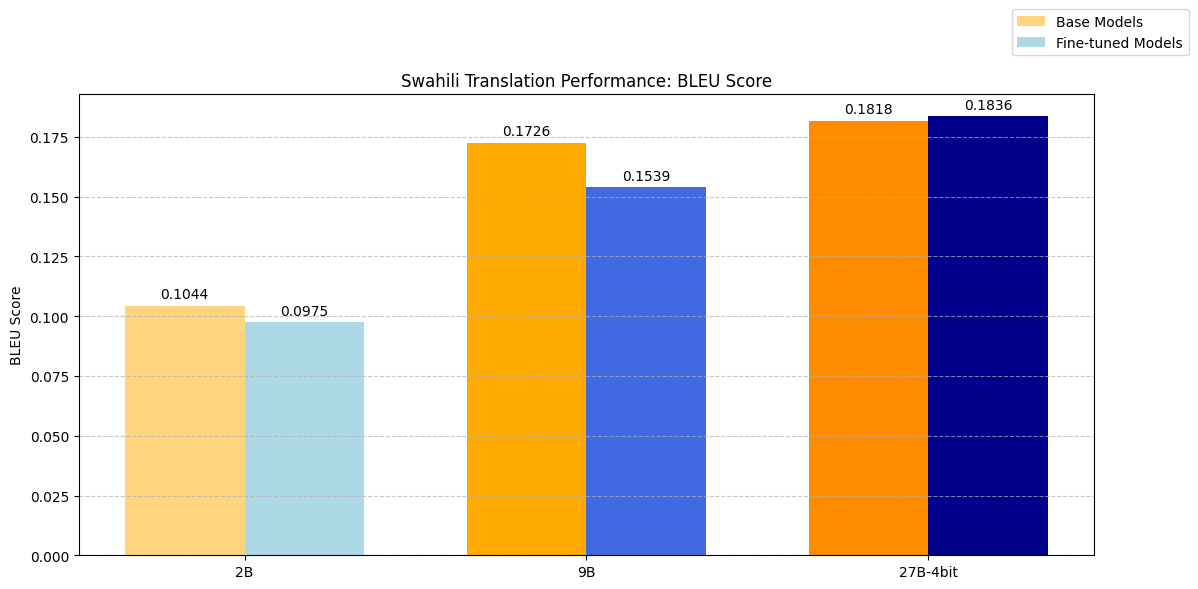

In [ ]:
# BLEU Score Plot
plt.figure(figsize=(12, 6))

# Prepare the translation scores
translation_scores = [
    (gemma2_2b_translation_scores, swahili_gemma2_2b_translation_scores),
    (gemma2_9b_translation_scores, swahili_gemma2_9b_translation_scores),
    (gemma2_27b_it_4bit_translation_scores, swahili_gemma2_27b_it_4bit_translation_scores)
]

# Position for bars
x = np.arange(3)
width = 0.35

# Colors for gradients
base_colors = ['#ffd580', '#ffaa00', '#ff8c00']  # Orange gradient
finetuned_colors = ['#add8e6', '#4169e1', '#00008b']  # Blue gradient

# Create bars
rects1 = plt.bar(x - width/2, [scores[0]['bleu'] for scores in translation_scores], width,
                 label='Base Models', color=base_colors)
rects2 = plt.bar(x + width/2, [scores[1]['bleu'] for scores in translation_scores], width,
                 label='Fine-tuned Models', color=finetuned_colors)

# Customize plot
plt.ylabel('BLEU Score')
plt.title('Swahili Translation Performance: BLEU Score')
plt.xticks(x, ['2B', '9B', '27B-4bit'])
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.2))

# Add value labels on bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        plt.annotate(f'{height:.4f}',
                     xy=(rect.get_x() + rect.get_width()/2, height),
                     xytext=(0, 3),  # 3 points vertical offset
                     textcoords="offset points",
                     ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

# Add grid for better readability
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Adjust layout and display
plt.tight_layout()
plt.show()

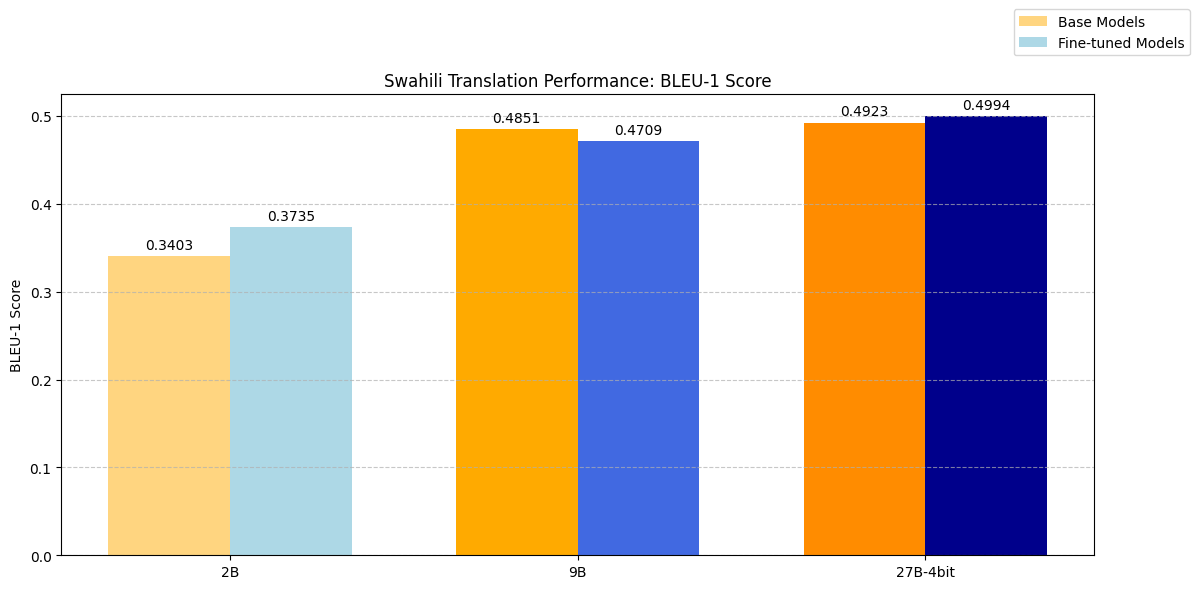

In [ ]:
# BLEU-1 Score Plot
plt.figure(figsize=(12, 6))

# Position for bars
x = np.arange(3)
width = 0.35

# Colors for gradients
base_colors = ['#ffd580', '#ffaa00', '#ff8c00']  # Orange gradient
finetuned_colors = ['#add8e6', '#4169e1', '#00008b']  # Blue gradient

# Create bars
rects1 = plt.bar(x - width/2, [scores[0]['bleu1'] for scores in translation_scores], width,
                 label='Base Models', color=base_colors)
rects2 = plt.bar(x + width/2, [scores[1]['bleu1'] for scores in translation_scores], width,
                 label='Fine-tuned Models', color=finetuned_colors)

# Customize plot
plt.ylabel('BLEU-1 Score')
plt.title('Swahili Translation Performance: BLEU-1 Score')
plt.xticks(x, ['2B', '9B', '27B-4bit'])
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.2))

# Add value labels on bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        plt.annotate(f'{height:.4f}',
                     xy=(rect.get_x() + rect.get_width()/2, height),
                     xytext=(0, 3),  # 3 points vertical offset
                     textcoords="offset points",
                     ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

# Add grid for better readability
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Adjust layout and display
plt.tight_layout()
plt.show()

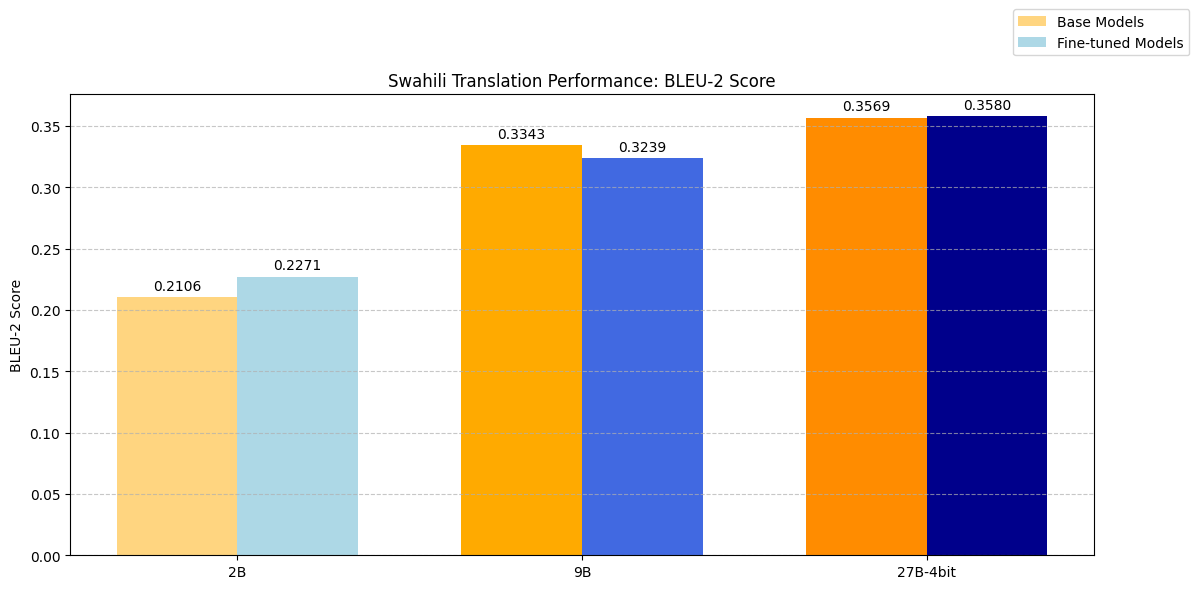

In [ ]:
# BLEU-2 Score Plot
plt.figure(figsize=(12, 6))

# Position for bars
x = np.arange(3)
width = 0.35

# Colors for gradients
base_colors = ['#ffd580', '#ffaa00', '#ff8c00']  # Orange gradient
finetuned_colors = ['#add8e6', '#4169e1', '#00008b']  # Blue gradient

# Create bars
rects1 = plt.bar(x - width/2, [scores[0]['bleu2'] for scores in translation_scores], width,
                 label='Base Models', color=base_colors)
rects2 = plt.bar(x + width/2, [scores[1]['bleu2'] for scores in translation_scores], width,
                 label='Fine-tuned Models', color=finetuned_colors)

# Customize plot
plt.ylabel('BLEU-2 Score')
plt.title('Swahili Translation Performance: BLEU-2 Score')
plt.xticks(x, ['2B', '9B', '27B-4bit'])
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.2))

# Add value labels on bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        plt.annotate(f'{height:.4f}',
                     xy=(rect.get_x() + rect.get_width()/2, height),
                     xytext=(0, 3),  # 3 points vertical offset
                     textcoords="offset points",
                     ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

# Add grid for better readability
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Adjust layout and display
plt.tight_layout()
plt.show()

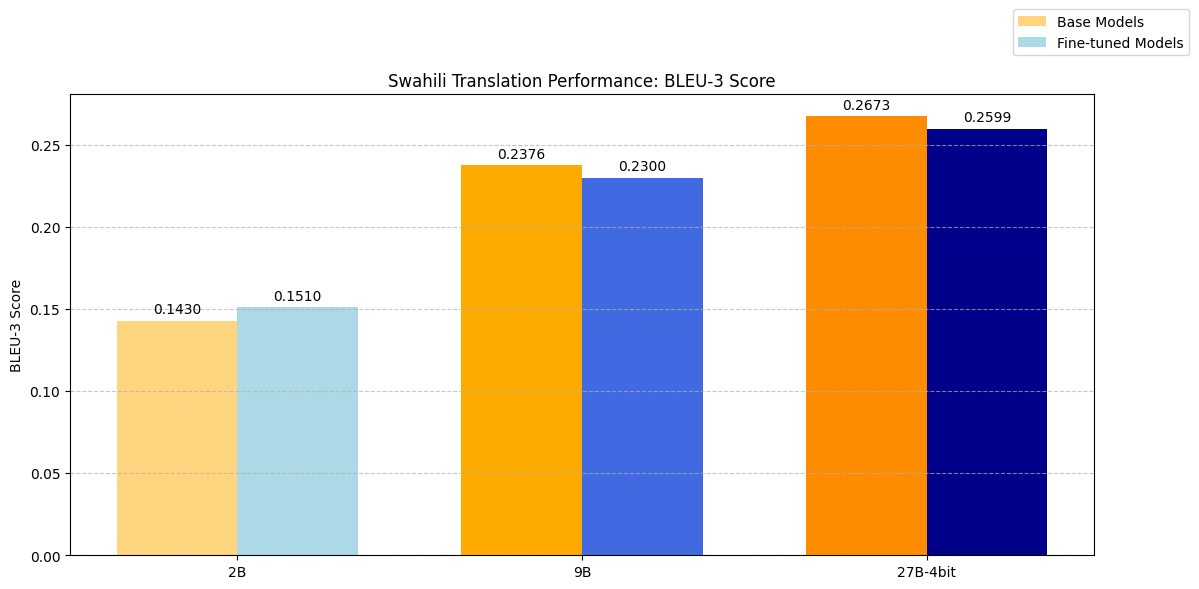

In [ ]:
# BLEU-3 Score Plot
plt.figure(figsize=(12, 6))

# Position for bars
x = np.arange(3)
width = 0.35

# Colors for gradients
base_colors = ['#ffd580', '#ffaa00', '#ff8c00']  # Orange gradient
finetuned_colors = ['#add8e6', '#4169e1', '#00008b']  # Blue gradient

# Create bars
rects1 = plt.bar(x - width/2, [scores[0]['bleu3'] for scores in translation_scores], width,
                 label='Base Models', color=base_colors)
rects2 = plt.bar(x + width/2, [scores[1]['bleu3'] for scores in translation_scores], width,
                 label='Fine-tuned Models', color=finetuned_colors)

# Customize plot
plt.ylabel('BLEU-3 Score')
plt.title('Swahili Translation Performance: BLEU-3 Score')
plt.xticks(x, ['2B', '9B', '27B-4bit'])
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.2))

# Add value labels on bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        plt.annotate(f'{height:.4f}',
                     xy=(rect.get_x() + rect.get_width()/2, height),
                     xytext=(0, 3),  # 3 points vertical offset
                     textcoords="offset points",
                     ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

# Add grid for better readability
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Adjust layout and display
plt.tight_layout()
plt.show()

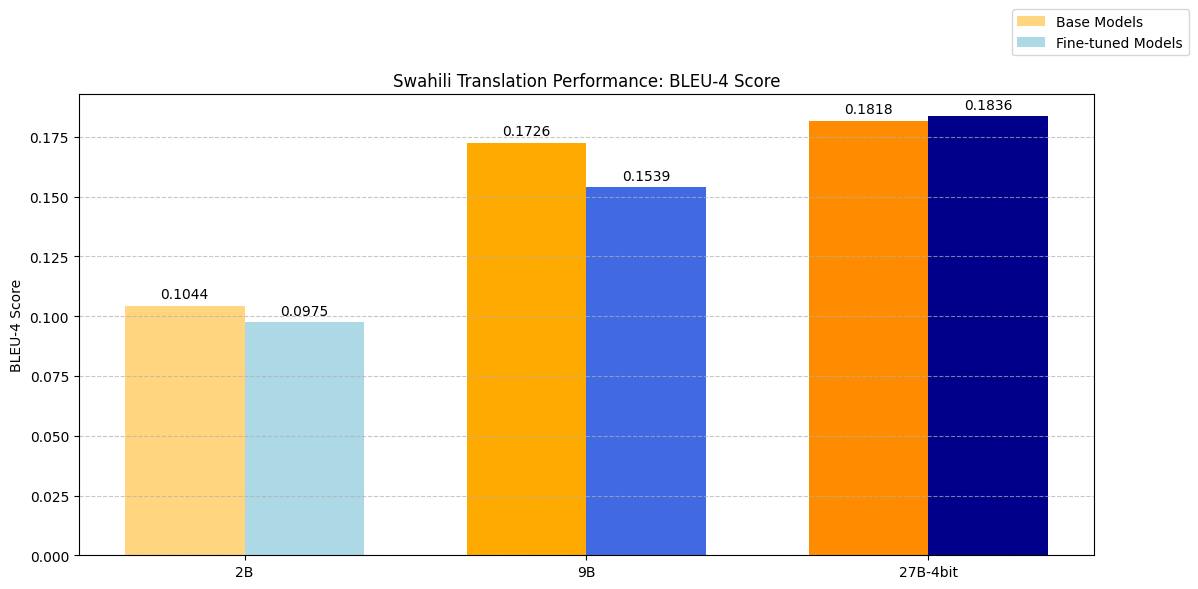

In [ ]:
# BLEU-4 Score Plot
plt.figure(figsize=(12, 6))

# Position for bars
x = np.arange(3)
width = 0.35

# Colors for gradients
base_colors = ['#ffd580', '#ffaa00', '#ff8c00']  # Orange gradient
finetuned_colors = ['#add8e6', '#4169e1', '#00008b']  # Blue gradient

# Create bars
rects1 = plt.bar(x - width/2, [scores[0]['bleu4'] for scores in translation_scores], width,
                 label='Base Models', color=base_colors)
rects2 = plt.bar(x + width/2, [scores[1]['bleu4'] for scores in translation_scores], width,
                 label='Fine-tuned Models', color=finetuned_colors)

# Customize plot
plt.ylabel('BLEU-4 Score')
plt.title('Swahili Translation Performance: BLEU-4 Score')
plt.xticks(x, ['2B', '9B', '27B-4bit'])
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.2))

# Add value labels on bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        plt.annotate(f'{height:.4f}',
                     xy=(rect.get_x() + rect.get_width()/2, height),
                     xytext=(0, 3),  # 3 points vertical offset
                     textcoords="offset points",
                     ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

# Add grid for better readability
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Adjust layout and display
plt.tight_layout()
plt.show()

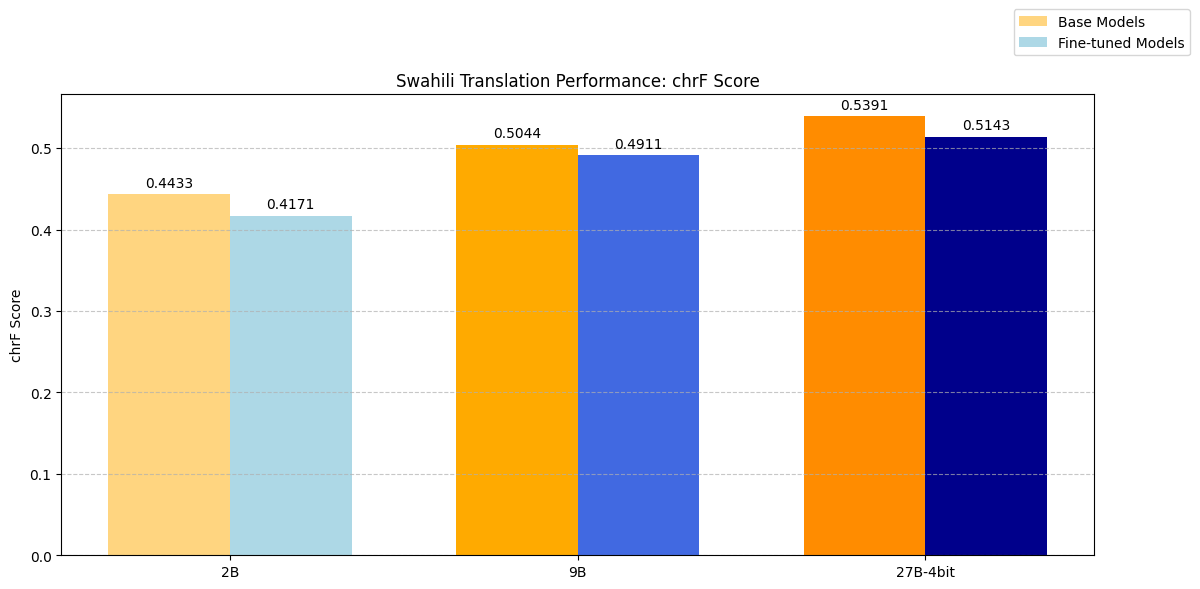

In [ ]:
# chrF Score Plot
plt.figure(figsize=(12, 6))

# Position for bars
x = np.arange(3)
width = 0.35

# Colors for gradients
base_colors = ['#ffd580', '#ffaa00', '#ff8c00']  # Orange gradient
finetuned_colors = ['#add8e6', '#4169e1', '#00008b']  # Blue gradient

# Create bars
rects1 = plt.bar(x - width/2, [scores[0]['chrf'] for scores in translation_scores], width,
                 label='Base Models', color=base_colors)
rects2 = plt.bar(x + width/2, [scores[1]['chrf'] for scores in translation_scores], width,
                 label='Fine-tuned Models', color=finetuned_colors)

# Customize plot
plt.ylabel('chrF Score')
plt.title('Swahili Translation Performance: chrF Score')
plt.xticks(x, ['2B', '9B', '27B-4bit'])
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.2))

# Add value labels on bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        plt.annotate(f'{height:.4f}',
                     xy=(rect.get_x() + rect.get_width()/2, height),
                     xytext=(0, 3),  # 3 points vertical offset
                     textcoords="offset points",
                     ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

# Add grid for better readability
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Adjust layout and display
plt.tight_layout()
plt.show()